In [ ]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
!pip install torchsummaryX
from torchsummaryX import summary
drive.mount('/gdrive/')

Mounted at /gdrive/


In [ ]:
import zipfile

!unzip '/gdrive/MyDrive/COMP4211 Project 1/Face Detection.zip'
print('Finished')

Archive:  /gdrive/MyDrive/COMP4211 Project 1/Face Detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  

# Extract Face Dataset

The original kaggle dataset contains images with multiple faces. We first need to extract the individual faces from the original dataset using the provided boundary boxes.

The dataset can be found here: https://www.kaggle.com/andrewmvd/face-mask-detection

In [ ]:
"""
Description: Define function to loop through data and save images. The images are saved in either
'not_wear_mask', 'wear_mask', or 'wear_mask_incorrectly' folders. Naming convention is 
maksssksksss{X}_{Y}.png, where X=raw image number, Y=number id of the cropped image

Input: directory of raw images and their annotations
Output: None. But, images are saved in the data folder
"""
def saveData(img_dir, anno_dir):
  # First, make dir if they don't exist already
  if os.path.isdir('/content/data'):
    return "Dataset Already Created"
  os.mkdir('/content/data')
  os.mkdir('/content/data/not_wear_mask')
  os.mkdir('/content/data/wear_mask')
  os.mkdir('/content/data/wear_mask_incorrectly')

  out_ls = []
  for i in range(853): # 853 imgs in dataset
    img_file = img_dir + '/maksssksksss{}.png'.format(i)
    curr_img = Image.open(img_file)

    # Parse annotation xml file
    anno_file = anno_dir + '/maksssksksss{}.xml'.format(i)
    anno_parsed = ET.parse(anno_file)
    objs = anno_parsed.findall('object')    
    #print(len(objs))

    dir_dict = {
      'without_mask':['not_wear_mask', 0],
      'with_mask':['wear_mask', 1],
      'mask_weared_incorrect':['wear_mask_incorrectly', 2]
    }

    for j, obj in enumerate(objs):
      # Determine unique name of this object
      filename = 'maksssksksss{}_{}.png'.format(i,j)

      # For each object, put all data into pandas dataframe
      name = obj.find('name').text
      dir_name = dir_dict[name][0]
      label = dir_dict[name][1]
      pose = obj.find('pose').text
      trunc = obj.find('truncated').text
      occ = obj.find('occluded').text
      diff = obj.find('difficult').text
      bb = obj.find('bndbox')
      bb_xmin = int(bb.find('xmin').text)
      bb_ymin = int(bb.find('ymin').text)
      bb_xmax = int(bb.find('xmax').text)
      bb_ymax = int(bb.find('ymax').text)
      out = [filename, dir_name, name, label, pose, trunc, occ, diff, bb_xmin, bb_ymin, bb_xmax, bb_ymax]
      out_ls.append(out)
      #print(out)
      
      # use PIL to crop image
      cut_img = curr_img.crop((bb_xmin, bb_ymin, bb_xmax, bb_ymax))
      out_file = '/content/data/' + dir_name + '/' + filename
      cut_img.save(out_file)
      #print(name)
      #display(cut_img)
  
  col = ['filename', 'dir_name', 'name', 'label', 'pose', 'trunc', 'occ', 'diff', 'bb_xmin', 'bb_ymin', 'bb_xmax', 'bb_ymax']
  data_df = pd.DataFrame(out_ls, columns=col)
  data_df.to_csv('index.csv')
  display(data_df)
  return "Dataset Created"

In [ ]:
saveData('/content/images', '/content/annotations')

filename       dir_name  ... bb_xmax  bb_ymax
0       maksssksksss0_0.png  not_wear_mask  ...     109      142
1       maksssksksss0_1.png      wear_mask  ...     226      144
2       maksssksksss0_2.png  not_wear_mask  ...     360      141
3       maksssksksss1_0.png      wear_mask  ...     354       69
4       maksssksksss1_1.png      wear_mask  ...     261       73
...                     ...            ...  ...     ...      ...
4067  maksssksksss850_1.png      wear_mask  ...     176       60
4068  maksssksksss850_2.png      wear_mask  ...     351       78
4069  maksssksksss851_0.png      wear_mask  ...     156      330
4070  maksssksksss852_0.png      wear_mask  ...     198      147
4071  maksssksksss852_1.png  not_wear_mask  ...     132      125

[4072 rows x 12 columns]

'Dataset Created'

In [ ]:
!zip -r '/content/data/wear_mask.zip' '/content/data/'

  adding: content/data/ (stored 0%)
  adding: content/data/not_wear_mask/ (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss296_7.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss773_8.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss486_2.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss453_16.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss559_13.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss680_4.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss777_5.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss453_4.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss64_4.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss240_0.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss518_26.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss280_18.png (stored 0%)
  adding: content/data/not_wear_mask/maksssksksss797_7.png 

# Create the new facemask dataset

Create the new class from the extracted faces

In [ ]:
data_df = pd.read_csv('index.csv', index_col=0) #I put 'index_col=0' to remove 'Unnamed:0' col
display(data_df['label'].value_counts())
data_df.head()

1    3232
0     717
2     123
Name: label, dtype: int64

filename       dir_name          name  ...  bb_ymin bb_xmax  bb_ymax
0  maksssksksss0_0.png  not_wear_mask  without_mask  ...      105     109      142
1  maksssksksss0_1.png      wear_mask     with_mask  ...      100     226      144
2  maksssksksss0_2.png  not_wear_mask  without_mask  ...       90     360      141
3  maksssksksss1_0.png      wear_mask     with_mask  ...       34     354       69
4  maksssksksss1_1.png      wear_mask     with_mask  ...       38     261       73

[5 rows x 12 columns]

In [ ]:
#splitting into training, validation, and testing set
from sklearn.model_selection import train_test_split
data_df1 = data_df
X = data_df1.drop('label', axis=1)
y = data_df1['label']
X_train, X_validtest, y_train, y_validtest = train_test_split(X,y, test_size=0.2, random_state=4211)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=4211)

#X_train.info()
#X_valid.info()
#X_test.info()

X_train['label'] = y_train
X_valid['label'] = y_valid
X_test['label'] = y_test

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

display(X_train['label'].value_counts())
display(X_valid['label'].value_counts())
display(X_test['label'].value_counts())

X_train.to_csv('train.csv')
X_valid.to_csv('valid.csv')
X_test.to_csv('test.csv')
print(len(X_train), len(X_valid), len(X_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

1    2566
0     591
2     100
Name: label, dtype: int64

1    329
0     63
2     15
Name: label, dtype: int64

1    337
0     63
2      8
Name: label, dtype: int64

3257 407 408


In [ ]:
# Dataset of the facemask images. Used to create an iterator when training the model
class FacemaskDataset(Dataset):
  def __init__(self, csv_file, transform=None, rgb=False):
    self.index_df = pd.read_csv(csv_file, index_col=0)
    self.transform = transform
    if rgb:
      self.is_rgb = True
    else:
      self.is_rgb = False

  def __getitem__(self, idx):
    img = os.path.join("/content/data/",self.index_df.loc[idx, 'dir_name'], self.index_df.loc[idx, 'filename'])
    image = Image.open(img)
    if self.is_rgb:
      image = image.convert('RGB')
    image_tr = self.transform(image)
    label = int(self.index_df.loc[idx, 'label'])
    return image_tr, label

  def __len__(self):
    return len(self.index_df)

In [ ]:
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),
      ])

dataset_train = FacemaskDataset(train_path, transform=transform0)
dataset_valid = FacemaskDataset(valid_path, transform=transform0)
dataset_test = FacemaskDataset(test_path, transform=transform0)

In [ ]:
#testing image display
img1, label = dataset_train[5]
plt.imshow(img1)
plt.show()
print(label)

1


In [ ]:
bs = 128

train_loader = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

dataiter = iter(train_loader)
image, label = next(dataiter)

# Build baseline model

Our first baseline model is PA2Net which is adapted from our COMP4211 PA2 model

In [ ]:
"""
Baseline model adapted from COMP4211 Spring 2021 PA2
"""

class PA2Net(nn.Module):
    def __init__(self, first_in_channel=1):
        super(PA2Net, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=first_in_channel, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.norm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.norm6 = nn.BatchNorm2d(512)
        self.pool2 = nn.AvgPool2d(16, 16, padding=0)

        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

        self.fully_connected = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,3)
        )
    
    
    def forward(self, x):
        # Convolution layers for the images
        x = F.relu(self.norm1(self.conv1(x))) #32, 32, 32 
        x = F.relu(self.norm2(self.conv2(x))) #32, 32, 32
        x = self.pool1(x) #32, 16, 16
        x = F.relu(self.norm3(self.conv3(x))) #64, 16, 16
        x = F.relu(self.norm4(self.conv4(x))) #128, 16, 16
        x = F.relu(self.norm5(self.conv5(x))) #256, 16, 16
        x = F.relu(self.norm6(self.conv6(x))) #512, 16, 16
        x = self.pool2(x) #512, 1, 1
        x = x.view(-1, 512)
  
        # Full connected layers and ouptut
        x = self.fully_connected(x)
        return x


In [ ]:
model = PA2Net()
summary(model, torch.zeros((1, 1, 32, 32)))

                                  Kernel Shape      Output Shape    Params  \
Layer                                                                        
0_conv1                          [1, 32, 3, 3]   [1, 32, 32, 32]     320.0   
1_norm1                                   [32]   [1, 32, 32, 32]      64.0   
2_conv2                         [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k   
3_norm2                                   [32]   [1, 32, 32, 32]      64.0   
4_pool1                                      -   [1, 32, 16, 16]         -   
5_conv3                         [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k   
6_norm3                                   [64]   [1, 64, 16, 16]     128.0   
7_conv4                        [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
8_norm4                                  [128]  [1, 128, 16, 16]     256.0   
9_conv5                       [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   
10_norm5                                 [256]  [1, 256, 16, 16]

Kernel Shape  ...    Mult-Adds
Layer                                           ...             
0_conv1                          [1, 32, 3, 3]  ...     294912.0
1_norm1                                   [32]  ...         32.0
2_conv2                         [32, 32, 3, 3]  ...    9437184.0
3_norm2                                   [32]  ...         32.0
4_pool1                                      -  ...          NaN
5_conv3                         [32, 64, 3, 3]  ...    4718592.0
6_norm3                                   [64]  ...         64.0
7_conv4                        [64, 128, 3, 3]  ...   18874368.0
8_norm4                                  [128]  ...        128.0
9_conv5                       [128, 256, 3, 3]  ...   75497472.0
10_norm5                                 [256]  ...        256.0
11_conv6                      [256, 512, 3, 3]  ...  301989888.0
12_norm6                                 [512]  ...        512.0
13_pool2                                     -  ...          NaN
14_fully_connected.Linear_0         [512, 512]  ...     262144.0
15_fully_connected.ReLU_1                    -  ...          NaN
16_fully_connected.Dropout_2                 -  ...          NaN
17_fully_connected.Linear_3           [512, 3]  ...       1536.0

[18 rows x 4 columns]

In [ ]:
"""
These helper functions are used to train the model and calculate performance metrics
These helper functions were adapted from our PA2 training functions
"""

def save_model(save_path, model):
    torch.save(model, save_path)
    print(f'Model saved to {save_path}')

def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, device, save_name):
    train_loss_ls = []
    val_loss_ls = []
    steps_ls = []
    step_count = 0
    best_model = None
    
    best_val_loss = float("Inf")
    best_macro_avg = 0
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_running_corrects = 0
        train_size = 0
        train_loss_count = 0
        for input_x, target in tqdm(train_loader):
            net.train()
            input_x = input_x.to(device)
            target = target.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = net(input_x)
            loss = criterion(outputs, target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step_count += 1
            train_loss_count += 1

            # Calculate the predictions and their accuracy
            preds = []
            for o in outputs:
                preds.append(torch.argmax(o))
            preds = torch.tensor(preds).to(device)
            train_running_loss += loss.item()
            train_running_corrects += torch.sum(preds == target.data)
            train_size += len(target)   
        
        # Calcualte train loss/acc
        train_loss = train_running_loss / train_loss_count
        train_acc = train_running_corrects / (train_size)
        
        # Every epoch, calculate val loss
        with torch.no_grad():
            net.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            pred_ls = []
            target_ls = []
            tmp_ls = []
            # Predict on validation dataset
            for input_x, target in valid_loader:

                input_x = input_x.to(device)
                target = target.to(device)

                outputs = net(input_x)
                loss = criterion(outputs, target)

                # Calculate loss and prediction
                val_running_loss += loss.item()
                preds = torch.argmax(outputs)
                val_running_corrects += torch.sum(preds == target.data)
                pred_ls.append(preds.item())
                target_ls.append(target.item())
            
            # Calculate performance metric for validation
            cr = classification_report(target_ls, pred_ls)
            cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
            macro_avg = cr_dict['macro avg']['f1-score']
            valid_loss = val_running_loss / len(valid_loader)
            valid_acc = val_running_corrects / float(len(valid_loader.dataset))
            

        # Save best macro average
        if macro_avg > best_macro_avg:
            best_macro_avg = macro_avg
            best_val_loss = valid_loss
            best_model = net
            save_model(save_name, net)

        # Store loss and accuracy in list for plotting
        train_loss_ls.append(train_loss)
        val_loss_ls.append(valid_loss)
        steps_ls.append(step_count)

        # print and continue
        print('Epoch [{}/{}], Step {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Macro Avg: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, step_count, train_loss, train_acc, macro_avg, valid_loss, valid_acc))
        print(cr)
        
    print('Finished Training')
    print('Best validation macro average:', best_macro_avg)
    print('Best validation loss:', best_val_loss)
    return train_loss_ls, val_loss_ls, steps_ls, best_model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2net_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_best.pt
Epoch [1/40], Step 26, Train Loss: 0.5061, Train Acc: 0.7789, Val Macro Avg: 0.4277, Valid Loss: 0.6785,  Valid Acc: 0.7420
              precision    recall  f1-score   support

           0       0.36      0.59      0.45        63
           1       0.87      0.81      0.84       329
           2       0.00      0.00      0.00        15

    accuracy                           0.74       407
   macro avg       0.41      0.46      0.43       407
weighted avg       0.76      0.74      0.75       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to pa2net_best.pt
Epoch [2/40], Step 52, Train Loss: 0.3893, Train Acc: 0.8621, Val Macro Avg: 0.5110, Valid Loss: 0.4519,  Valid Acc: 0.8452
              precision    recall  f1-score   support

           0       0.56      0.70      0.62        63
           1       0.91      0.91      0.91       329
           2       0.00      0.00      0.00        15

    accuracy                           0.85       407
   macro avg       0.49      0.54      0.51       407
weighted avg       0.83      0.85      0.83       407




Epoch [3/40], Step 78, Train Loss: 0.3932, Train Acc: 0.8569, Val Macro Avg: 0.5061, Valid Loss: 0.3895,  Valid Acc: 0.8673
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        63
           1       0.88      0.98      0.93       329
           2       0.00      0.00      0.00        15

    accuracy                           0.87       407
   macro avg       0.54      0.49      0.51       407
weighted avg       0.83      0.87      0.84       407




Model saved to pa2net_best.pt
Epoch [4/40], Step 104, Train Loss: 0.3604, Train Acc: 0.8671, Val Macro Avg: 0.5486, Valid Loss: 0.3762,  Valid Acc: 0.8845
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        63
           1       0.91      0.96      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.88       407
   macro avg       0.55      0.55      0.55       407
weighted avg       0.85      0.88      0.87       407




Model saved to pa2net_best.pt
Epoch [5/40], Step 130, Train Loss: 0.3281, Train Acc: 0.8846, Val Macro Avg: 0.5550, Valid Loss: 0.3287,  Valid Acc: 0.8894
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        63
           1       0.92      0.96      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.55      0.56      0.56       407
weighted avg       0.85      0.89      0.87       407




Epoch [6/40], Step 156, Train Loss: 0.3124, Train Acc: 0.8855, Val Macro Avg: 0.5076, Valid Loss: 0.4768,  Valid Acc: 0.8747
              precision    recall  f1-score   support

           0       0.96      0.43      0.59        63
           1       0.87      1.00      0.93       329
           2       0.00      0.00      0.00        15

    accuracy                           0.87       407
   macro avg       0.61      0.48      0.51       407
weighted avg       0.85      0.87      0.84       407




Model saved to pa2net_best.pt
Epoch [7/40], Step 182, Train Loss: 0.3032, Train Acc: 0.8876, Val Macro Avg: 0.5604, Valid Loss: 0.3595,  Valid Acc: 0.8870
              precision    recall  f1-score   support

           0       0.69      0.81      0.74        63
           1       0.93      0.94      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.54      0.58      0.56       407
weighted avg       0.86      0.89      0.87       407




Model saved to pa2net_best.pt
Epoch [8/40], Step 208, Train Loss: 0.2944, Train Acc: 0.8987, Val Macro Avg: 0.5804, Valid Loss: 0.2901,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        63
           1       0.95      0.95      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.55      0.62      0.58       407
weighted avg       0.88      0.90      0.89       407




Model saved to pa2net_best.pt
Epoch [9/40], Step 234, Train Loss: 0.2811, Train Acc: 0.8968, Val Macro Avg: 0.5844, Valid Loss: 0.2899,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.88      0.73      0.80        63
           1       0.92      0.99      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.60      0.57      0.58       407
weighted avg       0.88      0.91      0.89       407




Epoch [10/40], Step 260, Train Loss: 0.2557, Train Acc: 0.9082, Val Macro Avg: 0.5836, Valid Loss: 0.2321,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        63
           1       0.94      0.97      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.57      0.59      0.58       407
weighted avg       0.88      0.91      0.89       407




Model saved to pa2net_best.pt
Epoch [11/40], Step 286, Train Loss: 0.2407, Train Acc: 0.9091, Val Macro Avg: 0.5919, Valid Loss: 0.3528,  Valid Acc: 0.8870
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        63
           1       0.89      1.00      0.94       329
           2       0.33      0.13      0.19        15

    accuracy                           0.89       407
   macro avg       0.74      0.54      0.59       407
weighted avg       0.88      0.89      0.87       407




Model saved to pa2net_best.pt
Epoch [12/40], Step 312, Train Loss: 0.2249, Train Acc: 0.9146, Val Macro Avg: 0.6398, Valid Loss: 0.2227,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.92      0.63      0.64       407
weighted avg       0.93      0.92      0.91       407




Model saved to pa2net_best.pt
Epoch [13/40], Step 338, Train Loss: 0.2117, Train Acc: 0.9242, Val Macro Avg: 0.6875, Valid Loss: 0.2809,  Valid Acc: 0.8894
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        63
           1       0.94      0.93      0.94       329
           2       0.29      0.40      0.33        15

    accuracy                           0.89       407
   macro avg       0.68      0.70      0.69       407
weighted avg       0.90      0.89      0.89       407




Model saved to pa2net_best.pt
Epoch [14/40], Step 364, Train Loss: 0.1958, Train Acc: 0.9263, Val Macro Avg: 0.7453, Valid Loss: 0.2231,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.92      0.70      0.79        63
           1       0.94      0.98      0.96       329
           2       0.44      0.53      0.48        15

    accuracy                           0.92       407
   macro avg       0.77      0.74      0.75       407
weighted avg       0.92      0.92      0.92       407




Epoch [15/40], Step 390, Train Loss: 0.1873, Train Acc: 0.9266, Val Macro Avg: 0.6570, Valid Loss: 0.2846,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.73      0.92      0.82        63
           1       0.96      0.95      0.95       329
           2       0.40      0.13      0.20        15

    accuracy                           0.91       407
   macro avg       0.70      0.67      0.66       407
weighted avg       0.91      0.91      0.90       407




Epoch [16/40], Step 416, Train Loss: 0.1946, Train Acc: 0.9269, Val Macro Avg: 0.6015, Valid Loss: 0.3013,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.60      0.60      0.60       407
weighted avg       0.89      0.93      0.91       407




Epoch [17/40], Step 442, Train Loss: 0.1763, Train Acc: 0.9325, Val Macro Avg: 0.5728, Valid Loss: 0.4604,  Valid Acc: 0.9066
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        63
           1       0.91      0.99      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.61      0.55      0.57       407
weighted avg       0.87      0.91      0.89       407




Model saved to pa2net_best.pt
Epoch [18/40], Step 468, Train Loss: 0.1620, Train Acc: 0.9407, Val Macro Avg: 0.7846, Valid Loss: 0.2314,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        63
           1       0.94      0.98      0.96       329
           2       1.00      0.40      0.57        15

    accuracy                           0.93       407
   macro avg       0.93      0.73      0.78       407
weighted avg       0.93      0.93      0.92       407




Epoch [19/40], Step 494, Train Loss: 0.1775, Train Acc: 0.9361, Val Macro Avg: 0.7685, Valid Loss: 0.2164,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        63
           1       0.97      0.93      0.95       329
           2       0.47      0.60      0.53        15

    accuracy                           0.91       407
   macro avg       0.74      0.80      0.77       407
weighted avg       0.92      0.91      0.91       407




Epoch [20/40], Step 520, Train Loss: 0.1625, Train Acc: 0.9352, Val Macro Avg: 0.7645, Valid Loss: 0.2016,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        63
           1       0.95      0.97      0.96       329
           2       1.00      0.33      0.50        15

    accuracy                           0.93       407
   macro avg       0.92      0.72      0.76       407
weighted avg       0.93      0.93      0.92       407




Model saved to pa2net_best.pt
Epoch [21/40], Step 546, Train Loss: 0.1390, Train Acc: 0.9466, Val Macro Avg: 0.7865, Valid Loss: 0.2087,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        63
           1       0.96      0.97      0.96       329
           2       0.56      0.60      0.58        15

    accuracy                           0.93       407
   macro avg       0.79      0.78      0.79       407
weighted avg       0.93      0.93      0.93       407




Epoch [22/40], Step 572, Train Loss: 0.1593, Train Acc: 0.9404, Val Macro Avg: 0.7048, Valid Loss: 0.3791,  Valid Acc: 0.8501
              precision    recall  f1-score   support

           0       0.56      0.95      0.71        63
           1       0.98      0.84      0.91       329
           2       0.47      0.53      0.50        15

    accuracy                           0.85       407
   macro avg       0.67      0.78      0.70       407
weighted avg       0.90      0.85      0.86       407




Epoch [23/40], Step 598, Train Loss: 0.1418, Train Acc: 0.9441, Val Macro Avg: 0.6163, Valid Loss: 0.3372,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.90      0.68      0.77        63
           1       0.91      0.99      0.95       329
           2       1.00      0.07      0.12        15

    accuracy                           0.91       407
   macro avg       0.94      0.58      0.62       407
weighted avg       0.91      0.91      0.89       407




Epoch [24/40], Step 624, Train Loss: 0.1383, Train Acc: 0.9484, Val Macro Avg: 0.6437, Valid Loss: 0.4642,  Valid Acc: 0.8182
              precision    recall  f1-score   support

           0       0.65      0.87      0.75        63
           1       0.97      0.82      0.89       329
           2       0.20      0.60      0.30        15

    accuracy                           0.82       407
   macro avg       0.61      0.76      0.64       407
weighted avg       0.89      0.82      0.84       407




Epoch [25/40], Step 650, Train Loss: 0.1238, Train Acc: 0.9536, Val Macro Avg: 0.6502, Valid Loss: 0.4738,  Valid Acc: 0.8305
              precision    recall  f1-score   support

           0       0.50      0.95      0.65        63
           1       0.98      0.83      0.90       329
           2       0.80      0.27      0.40        15

    accuracy                           0.83       407
   macro avg       0.76      0.68      0.65       407
weighted avg       0.89      0.83      0.84       407




Epoch [26/40], Step 676, Train Loss: 0.1082, Train Acc: 0.9595, Val Macro Avg: 0.7489, Valid Loss: 0.2277,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        63
           1       0.96      0.97      0.97       329
           2       0.71      0.33      0.45        15

    accuracy                           0.93       407
   macro avg       0.82      0.72      0.75       407
weighted avg       0.93      0.93      0.92       407




Epoch [27/40], Step 702, Train Loss: 0.0985, Train Acc: 0.9635, Val Macro Avg: 0.6362, Valid Loss: 0.3848,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.92      0.62      0.64       407
weighted avg       0.92      0.92      0.91       407




Epoch [28/40], Step 728, Train Loss: 0.1066, Train Acc: 0.9558, Val Macro Avg: 0.7062, Valid Loss: 0.3125,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       1.00      0.49      0.66        63
           1       0.92      1.00      0.96       329
           2       0.43      0.60      0.50        15

    accuracy                           0.90       407
   macro avg       0.78      0.70      0.71       407
weighted avg       0.92      0.90      0.90       407




Model saved to pa2net_best.pt
Epoch [29/40], Step 754, Train Loss: 0.1188, Train Acc: 0.9546, Val Macro Avg: 0.7985, Valid Loss: 0.2204,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        63
           1       0.98      0.97      0.97       329
           2       0.86      0.40      0.55        15

    accuracy                           0.95       407
   macro avg       0.88      0.77      0.80       407
weighted avg       0.95      0.95      0.94       407




Epoch [30/40], Step 780, Train Loss: 0.0865, Train Acc: 0.9699, Val Macro Avg: 0.7317, Valid Loss: 0.2358,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        63
           1       0.94      0.99      0.96       329
           2       0.80      0.27      0.40        15

    accuracy                           0.93       407
   macro avg       0.88      0.68      0.73       407
weighted avg       0.93      0.93      0.92       407




Epoch [31/40], Step 806, Train Loss: 0.0840, Train Acc: 0.9705, Val Macro Avg: 0.6536, Valid Loss: 0.5647,  Valid Acc: 0.8084
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        63
           1       0.97      0.81      0.88       329
           2       0.18      0.80      0.30        15

    accuracy                           0.81       407
   macro avg       0.64      0.81      0.65       407
weighted avg       0.91      0.81      0.84       407




Epoch [32/40], Step 832, Train Loss: 0.0811, Train Acc: 0.9696, Val Macro Avg: 0.7066, Valid Loss: 0.3222,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        63
           1       0.94      0.98      0.96       329
           2       1.00      0.20      0.33        15

    accuracy                           0.93       407
   macro avg       0.92      0.67      0.71       407
weighted avg       0.93      0.93      0.92       407




Epoch [33/40], Step 858, Train Loss: 0.1033, Train Acc: 0.9604, Val Macro Avg: 0.7546, Valid Loss: 0.2558,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        63
           1       0.96      0.97      0.96       329
           2       1.00      0.33      0.50        15

    accuracy                           0.93       407
   macro avg       0.91      0.71      0.75       407
weighted avg       0.93      0.93      0.92       407




Epoch [34/40], Step 884, Train Loss: 0.0748, Train Acc: 0.9711, Val Macro Avg: 0.7971, Valid Loss: 0.2447,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        63
           1       0.97      0.98      0.97       329
           2       1.00      0.40      0.57        15

    accuracy                           0.94       407
   macro avg       0.93      0.75      0.80       407
weighted avg       0.94      0.94      0.94       407




Epoch [35/40], Step 910, Train Loss: 0.0586, Train Acc: 0.9776, Val Macro Avg: 0.7169, Valid Loss: 0.2474,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        63
           1       0.94      0.99      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.94       407
   macro avg       0.95      0.67      0.72       407
weighted avg       0.94      0.94      0.93       407




Epoch [36/40], Step 936, Train Loss: 0.0717, Train Acc: 0.9714, Val Macro Avg: 0.7955, Valid Loss: 0.2693,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        63
           1       0.93      0.98      0.96       329
           2       0.64      0.60      0.62        15

    accuracy                           0.93       407
   macro avg       0.84      0.76      0.80       407
weighted avg       0.93      0.93      0.92       407




Epoch [37/40], Step 962, Train Loss: 0.0741, Train Acc: 0.9739, Val Macro Avg: 0.7722, Valid Loss: 0.2978,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        63
           1       0.95      0.98      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.94       407
   macro avg       0.94      0.72      0.77       407
weighted avg       0.94      0.94      0.93       407




Epoch [38/40], Step 988, Train Loss: 0.1070, Train Acc: 0.9582, Val Macro Avg: 0.7078, Valid Loss: 0.2867,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        63
           1       0.96      0.97      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.93       407
   macro avg       0.91      0.69      0.71       407
weighted avg       0.93      0.93      0.92       407




Model saved to pa2net_best.pt
Epoch [39/40], Step 1014, Train Loss: 0.0696, Train Acc: 0.9739, Val Macro Avg: 0.8131, Valid Loss: 0.2287,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        63
           1       0.94      0.99      0.96       329
           2       0.80      0.53      0.64        15

    accuracy                           0.94       407
   macro avg       0.89      0.76      0.81       407
weighted avg       0.93      0.94      0.93       407




Epoch [40/40], Step 1040, Train Loss: 0.0516, Train Acc: 0.9828, Val Macro Avg: 0.7688, Valid Loss: 0.2970,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        63
           1       0.95      0.99      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.94       407
   macro avg       0.94      0.71      0.77       407
weighted avg       0.94      0.94      0.93       407

Finished Training
Best validation macro average: 0.8130581000301037
Best validation loss: 0.22867945159210565


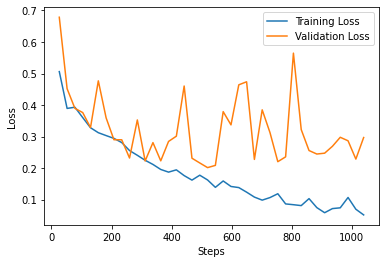

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

# Experiment 1: Image Transformations

Use transformed images on PA2Net 

In [ ]:
# Load in transformed datasets

train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform_train = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.Grayscale(num_output_channels=1),
      transforms.RandomRotation(10),
      transforms.ToTensor(), 
      #transforms.Normalize((0.5, ), (0.5, )),
      ])

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    
      ])

dataset_train = FacemaskDataset(train_path, transform=transform_train)
dataset_valid = FacemaskDataset(valid_path, transform=transform_original)
dataset_test = FacemaskDataset(test_path, transform=transform_original)

In [ ]:
bs = 128

train_loader_trans = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_trans = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_trans = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Test using PA2 Model + transformation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 60
criterion = nn.CrossEntropyLoss()
save_path = f'transformations_pa2net_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_trans, valid_loader_trans, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to transformations_pa2net_best.pt
Epoch [1/60], Step 26, Train Loss: 0.5167, Train Acc: 0.8099, Val Macro Avg: 0.2070, Valid Loss: 1.2742,  Valid Acc: 0.3047
              precision    recall  f1-score   support

           0       0.18      0.98      0.31        63
           1       0.97      0.19      0.32       329
           2       0.00      0.00      0.00        15

    accuracy                           0.30       407
   macro avg       0.38      0.39      0.21       407
weighted avg       0.81      0.30      0.30       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to transformations_pa2net_best.pt
Epoch [2/60], Step 52, Train Loss: 0.4080, Train Acc: 0.8428, Val Macro Avg: 0.5251, Valid Loss: 0.4033,  Valid Acc: 0.8575
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        63
           1       0.91      0.92      0.92       329
           2       0.00      0.00      0.00        15

    accuracy                           0.86       407
   macro avg       0.51      0.55      0.53       407
weighted avg       0.83      0.86      0.84       407




Epoch [3/60], Step 78, Train Loss: 0.3920, Train Acc: 0.8514, Val Macro Avg: 0.4353, Valid Loss: 0.6113,  Valid Acc: 0.8428
              precision    recall  f1-score   support

           0       0.89      0.25      0.40        63
           1       0.84      0.99      0.91       329
           2       0.00      0.00      0.00        15

    accuracy                           0.84       407
   macro avg       0.58      0.42      0.44       407
weighted avg       0.82      0.84      0.80       407




Model saved to transformations_pa2net_best.pt
Epoch [4/60], Step 104, Train Loss: 0.3953, Train Acc: 0.8575, Val Macro Avg: 0.5318, Valid Loss: 0.3979,  Valid Acc: 0.8600
              precision    recall  f1-score   support

           0       0.61      0.76      0.68        63
           1       0.92      0.92      0.92       329
           2       0.00      0.00      0.00        15

    accuracy                           0.86       407
   macro avg       0.51      0.56      0.53       407
weighted avg       0.84      0.86      0.85       407




Epoch [5/60], Step 130, Train Loss: 0.3825, Train Acc: 0.8523, Val Macro Avg: 0.5039, Valid Loss: 0.4296,  Valid Acc: 0.8501
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        63
           1       0.90      0.94      0.92       329
           2       0.00      0.00      0.00        15

    accuracy                           0.85       407
   macro avg       0.50      0.51      0.50       407
weighted avg       0.82      0.85      0.83       407




Epoch [6/60], Step 156, Train Loss: 0.3555, Train Acc: 0.8655, Val Macro Avg: 0.5028, Valid Loss: 0.4480,  Valid Acc: 0.8206
              precision    recall  f1-score   support

           0       0.49      0.83      0.61        63
           1       0.94      0.86      0.90       329
           2       0.00      0.00      0.00        15

    accuracy                           0.82       407
   macro avg       0.48      0.56      0.50       407
weighted avg       0.84      0.82      0.82       407




Epoch [7/60], Step 182, Train Loss: 0.3323, Train Acc: 0.8750, Val Macro Avg: 0.4910, Valid Loss: 0.4738,  Valid Acc: 0.7887
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        63
           1       0.96      0.79      0.87       329
           2       0.00      0.00      0.00        15

    accuracy                           0.79       407
   macro avg       0.47      0.58      0.49       407
weighted avg       0.85      0.79      0.80       407




Model saved to transformations_pa2net_best.pt
Epoch [8/60], Step 208, Train Loss: 0.3250, Train Acc: 0.8815, Val Macro Avg: 0.5455, Valid Loss: 0.3909,  Valid Acc: 0.8894
              precision    recall  f1-score   support

           0       0.83      0.60      0.70        63
           1       0.90      0.98      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.57      0.53      0.55       407
weighted avg       0.85      0.89      0.87       407




Epoch [9/60], Step 234, Train Loss: 0.3313, Train Acc: 0.8753, Val Macro Avg: 0.5415, Valid Loss: 0.4361,  Valid Acc: 0.8894
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        63
           1       0.89      0.99      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.60      0.52      0.54       407
weighted avg       0.86      0.89      0.86       407




Model saved to transformations_pa2net_best.pt
Epoch [10/60], Step 260, Train Loss: 0.2948, Train Acc: 0.8953, Val Macro Avg: 0.5754, Valid Loss: 0.3210,  Valid Acc: 0.9017
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        63
           1       0.93      0.96      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.57      0.59      0.58       407
weighted avg       0.87      0.90      0.88       407




Epoch [11/60], Step 286, Train Loss: 0.2988, Train Acc: 0.8864, Val Macro Avg: 0.5292, Valid Loss: 0.3562,  Valid Acc: 0.8821
              precision    recall  f1-score   support

           0       0.87      0.52      0.65        63
           1       0.88      0.99      0.93       329
           2       0.00      0.00      0.00        15

    accuracy                           0.88       407
   macro avg       0.58      0.50      0.53       407
weighted avg       0.85      0.88      0.86       407




Epoch [12/60], Step 312, Train Loss: 0.2818, Train Acc: 0.8962, Val Macro Avg: 0.4294, Valid Loss: 0.7181,  Valid Acc: 0.7002
              precision    recall  f1-score   support

           0       0.33      0.87      0.48        63
           1       0.95      0.70      0.81       329
           2       0.00      0.00      0.00        15

    accuracy                           0.70       407
   macro avg       0.43      0.52      0.43       407
weighted avg       0.82      0.70      0.73       407




Epoch [13/60], Step 338, Train Loss: 0.2729, Train Acc: 0.8959, Val Macro Avg: 0.5462, Valid Loss: 0.4073,  Valid Acc: 0.8919
              precision    recall  f1-score   support

           0       0.90      0.57      0.70        63
           1       0.89      0.99      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.60      0.52      0.55       407
weighted avg       0.86      0.89      0.87       407




Model saved to transformations_pa2net_best.pt
Epoch [14/60], Step 364, Train Loss: 0.2719, Train Acc: 0.9008, Val Macro Avg: 0.6564, Valid Loss: 0.2732,  Valid Acc: 0.8870
              precision    recall  f1-score   support

           0       0.67      0.84      0.75        63
           1       0.95      0.93      0.94       329
           2       0.50      0.20      0.29        15

    accuracy                           0.89       407
   macro avg       0.71      0.66      0.66       407
weighted avg       0.89      0.89      0.88       407




Epoch [15/60], Step 390, Train Loss: 0.2450, Train Acc: 0.9067, Val Macro Avg: 0.5706, Valid Loss: 0.2626,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        63
           1       0.94      0.95      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.55      0.59      0.57       407
weighted avg       0.87      0.90      0.88       407




Epoch [16/60], Step 416, Train Loss: 0.2445, Train Acc: 0.9070, Val Macro Avg: 0.5757, Valid Loss: 0.3927,  Valid Acc: 0.8182
              precision    recall  f1-score   support

           0       0.48      0.89      0.62        63
           1       0.96      0.84      0.89       329
           2       0.50      0.13      0.21        15

    accuracy                           0.82       407
   macro avg       0.65      0.62      0.58       407
weighted avg       0.87      0.82      0.83       407




Model saved to transformations_pa2net_best.pt
Epoch [17/60], Step 442, Train Loss: 0.2382, Train Acc: 0.9137, Val Macro Avg: 0.7236, Valid Loss: 0.2277,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        63
           1       0.93      0.97      0.95       329
           2       0.62      0.33      0.43        15

    accuracy                           0.91       407
   macro avg       0.80      0.68      0.72       407
weighted avg       0.90      0.91      0.91       407




Model saved to transformations_pa2net_best.pt
Epoch [18/60], Step 468, Train Loss: 0.2278, Train Acc: 0.9128, Val Macro Avg: 0.8057, Valid Loss: 0.2485,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        63
           1       0.97      0.95      0.96       329
           2       0.80      0.53      0.64        15

    accuracy                           0.92       407
   macro avg       0.84      0.79      0.81       407
weighted avg       0.93      0.92      0.92       407




Epoch [19/60], Step 494, Train Loss: 0.2127, Train Acc: 0.9208, Val Macro Avg: 0.6858, Valid Loss: 0.2449,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        63
           1       0.96      0.92      0.94       329
           2       1.00      0.20      0.33        15

    accuracy                           0.90       407
   macro avg       0.88      0.69      0.69       407
weighted avg       0.92      0.90      0.90       407




Epoch [20/60], Step 520, Train Loss: 0.2169, Train Acc: 0.9229, Val Macro Avg: 0.7863, Valid Loss: 0.2007,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        63
           1       0.95      0.98      0.97       329
           2       0.86      0.40      0.55        15

    accuracy                           0.94       407
   macro avg       0.89      0.74      0.79       407
weighted avg       0.93      0.94      0.93       407




Epoch [21/60], Step 546, Train Loss: 0.2075, Train Acc: 0.9251, Val Macro Avg: 0.5627, Valid Loss: 0.6801,  Valid Acc: 0.6904
              precision    recall  f1-score   support

           0       0.34      0.95      0.50        63
           1       0.97      0.66      0.78       329
           2       0.50      0.33      0.40        15

    accuracy                           0.69       407
   macro avg       0.61      0.65      0.56       407
weighted avg       0.86      0.69      0.73       407




Epoch [22/60], Step 572, Train Loss: 0.2006, Train Acc: 0.9229, Val Macro Avg: 0.6708, Valid Loss: 0.2466,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        63
           1       0.94      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.92       407
   macro avg       0.92      0.64      0.67       407
weighted avg       0.92      0.92      0.91       407




Epoch [23/60], Step 598, Train Loss: 0.2024, Train Acc: 0.9260, Val Macro Avg: 0.7081, Valid Loss: 0.3248,  Valid Acc: 0.8673
              precision    recall  f1-score   support

           0       0.66      0.94      0.78        63
           1       0.98      0.87      0.92       329
           2       0.33      0.60      0.43        15

    accuracy                           0.87       407
   macro avg       0.66      0.80      0.71       407
weighted avg       0.91      0.87      0.88       407




Epoch [24/60], Step 624, Train Loss: 0.1980, Train Acc: 0.9260, Val Macro Avg: 0.6045, Valid Loss: 0.3029,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.62      0.60      0.60       407
weighted avg       0.89      0.93      0.91       407




Epoch [25/60], Step 650, Train Loss: 0.1852, Train Acc: 0.9294, Val Macro Avg: 0.6961, Valid Loss: 0.3217,  Valid Acc: 0.8501
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        63
           1       0.97      0.86      0.91       329
           2       0.28      0.80      0.41        15

    accuracy                           0.85       407
   macro avg       0.65      0.83      0.70       407
weighted avg       0.90      0.85      0.87       407




Epoch [26/60], Step 676, Train Loss: 0.1841, Train Acc: 0.9288, Val Macro Avg: 0.5711, Valid Loss: 0.3445,  Valid Acc: 0.8943
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        63
           1       0.95      0.93      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.89       407
   macro avg       0.54      0.61      0.57       407
weighted avg       0.87      0.89      0.88       407




Epoch [27/60], Step 702, Train Loss: 0.1843, Train Acc: 0.9248, Val Macro Avg: 0.7698, Valid Loss: 0.2305,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        63
           1       0.96      0.97      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.93       407
   macro avg       0.92      0.73      0.77       407
weighted avg       0.94      0.93      0.93       407




Epoch [28/60], Step 728, Train Loss: 0.1853, Train Acc: 0.9288, Val Macro Avg: 0.7248, Valid Loss: 0.3076,  Valid Acc: 0.8845
              precision    recall  f1-score   support

           0       0.61      0.95      0.74        63
           1       0.97      0.90      0.93       329
           2       1.00      0.33      0.50        15

    accuracy                           0.88       407
   macro avg       0.86      0.73      0.72       407
weighted avg       0.92      0.88      0.89       407




Model saved to transformations_pa2net_best.pt
Epoch [29/60], Step 754, Train Loss: 0.1809, Train Acc: 0.9309, Val Macro Avg: 0.8545, Valid Loss: 0.1730,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        63
           1       0.96      0.98      0.97       329
           2       1.00      0.60      0.75        15

    accuracy                           0.94       407
   macro avg       0.93      0.81      0.85       407
weighted avg       0.94      0.94      0.94       407




Epoch [30/60], Step 780, Train Loss: 0.1567, Train Acc: 0.9414, Val Macro Avg: 0.7206, Valid Loss: 0.1805,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        63
           1       0.96      0.98      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.94       407
   macro avg       0.93      0.69      0.72       407
weighted avg       0.94      0.94      0.93       407




Epoch [31/60], Step 806, Train Loss: 0.1677, Train Acc: 0.9340, Val Macro Avg: 0.6792, Valid Loss: 0.2146,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        63
           1       0.93      0.99      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.95      0.63      0.68       407
weighted avg       0.93      0.93      0.91       407




Epoch [32/60], Step 832, Train Loss: 0.1604, Train Acc: 0.9371, Val Macro Avg: 0.7813, Valid Loss: 0.2290,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        63
           1       0.96      0.97      0.97       329
           2       0.50      0.60      0.55        15

    accuracy                           0.93       407
   macro avg       0.78      0.79      0.78       407
weighted avg       0.93      0.93      0.93       407




Epoch [33/60], Step 858, Train Loss: 0.1602, Train Acc: 0.9349, Val Macro Avg: 0.8088, Valid Loss: 0.1791,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.87      0.86      0.86        63
           1       0.96      0.98      0.97       329
           2       0.67      0.53      0.59        15

    accuracy                           0.94       407
   macro avg       0.83      0.79      0.81       407
weighted avg       0.94      0.94      0.94       407




Epoch [34/60], Step 884, Train Loss: 0.1629, Train Acc: 0.9364, Val Macro Avg: 0.6315, Valid Loss: 0.2471,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        63
           1       0.93      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.93      0.61      0.63       407
weighted avg       0.92      0.92      0.90       407




Epoch [35/60], Step 910, Train Loss: 0.1578, Train Acc: 0.9374, Val Macro Avg: 0.8165, Valid Loss: 0.2147,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        63
           1       0.93      1.00      0.96       329
           2       0.89      0.53      0.67        15

    accuracy                           0.94       407
   macro avg       0.93      0.75      0.82       407
weighted avg       0.94      0.94      0.93       407




Epoch [36/60], Step 936, Train Loss: 0.1440, Train Acc: 0.9463, Val Macro Avg: 0.6790, Valid Loss: 0.2788,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        63
           1       0.94      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.93      0.65      0.68       407
weighted avg       0.93      0.93      0.92       407




Epoch [37/60], Step 962, Train Loss: 0.1459, Train Acc: 0.9398, Val Macro Avg: 0.8126, Valid Loss: 0.2070,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        63
           1       0.93      0.99      0.96       329
           2       0.89      0.53      0.67        15

    accuracy                           0.93       407
   macro avg       0.92      0.75      0.81       407
weighted avg       0.93      0.93      0.93       407




Epoch [38/60], Step 988, Train Loss: 0.1378, Train Acc: 0.9472, Val Macro Avg: 0.8038, Valid Loss: 0.2035,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        63
           1       0.96      0.98      0.97       329
           2       1.00      0.40      0.57        15

    accuracy                           0.94       407
   macro avg       0.93      0.76      0.80       407
weighted avg       0.95      0.94      0.94       407




Epoch [39/60], Step 1014, Train Loss: 0.1564, Train Acc: 0.9386, Val Macro Avg: 0.6882, Valid Loss: 0.2464,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       0.88      0.60      0.72        63
           1       0.91      0.99      0.95       329
           2       0.80      0.27      0.40        15

    accuracy                           0.90       407
   macro avg       0.86      0.62      0.69       407
weighted avg       0.90      0.90      0.89       407




Epoch [40/60], Step 1040, Train Loss: 0.1353, Train Acc: 0.9487, Val Macro Avg: 0.5979, Valid Loss: 0.3333,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        63
           1       0.92      1.00      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.62      0.59      0.60       407
weighted avg       0.89      0.92      0.90       407




Epoch [41/60], Step 1066, Train Loss: 0.1375, Train Acc: 0.9484, Val Macro Avg: 0.7781, Valid Loss: 0.2071,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        63
           1       0.96      0.95      0.95       329
           2       0.44      0.73      0.55        15

    accuracy                           0.91       407
   macro avg       0.76      0.82      0.78       407
weighted avg       0.93      0.91      0.92       407




Epoch [42/60], Step 1092, Train Loss: 0.1271, Train Acc: 0.9533, Val Macro Avg: 0.7432, Valid Loss: 0.2732,  Valid Acc: 0.8919
              precision    recall  f1-score   support

           0       0.63      0.90      0.75        63
           1       0.97      0.91      0.94       329
           2       0.86      0.40      0.55        15

    accuracy                           0.89       407
   macro avg       0.82      0.74      0.74       407
weighted avg       0.91      0.89      0.89       407




Epoch [43/60], Step 1118, Train Loss: 0.1158, Train Acc: 0.9493, Val Macro Avg: 0.7580, Valid Loss: 0.2607,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.73      0.92      0.82        63
           1       0.97      0.95      0.96       329
           2       1.00      0.33      0.50        15

    accuracy                           0.92       407
   macro avg       0.90      0.73      0.76       407
weighted avg       0.93      0.92      0.92       407




Model saved to transformations_pa2net_best.pt
Epoch [44/60], Step 1144, Train Loss: 0.1205, Train Acc: 0.9555, Val Macro Avg: 0.8666, Valid Loss: 0.1738,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        63
           1       0.95      0.99      0.97       329
           2       0.83      0.67      0.74        15

    accuracy                           0.95       407
   macro avg       0.92      0.83      0.87       407
weighted avg       0.95      0.95      0.95       407




Epoch [45/60], Step 1170, Train Loss: 0.1216, Train Acc: 0.9530, Val Macro Avg: 0.7222, Valid Loss: 0.3461,  Valid Acc: 0.8550
              precision    recall  f1-score   support

           0       0.55      0.86      0.67        63
           1       0.96      0.87      0.91       329
           2       0.78      0.47      0.58        15

    accuracy                           0.86       407
   macro avg       0.76      0.73      0.72       407
weighted avg       0.89      0.86      0.86       407




Epoch [46/60], Step 1196, Train Loss: 0.1178, Train Acc: 0.9570, Val Macro Avg: 0.7344, Valid Loss: 0.2619,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        63
           1       0.93      0.99      0.96       329
           2       1.00      0.27      0.42        15

    accuracy                           0.93       407
   macro avg       0.94      0.67      0.73       407
weighted avg       0.93      0.93      0.92       407




Epoch [47/60], Step 1222, Train Loss: 0.1216, Train Acc: 0.9500, Val Macro Avg: 0.7102, Valid Loss: 0.4068,  Valid Acc: 0.8501
              precision    recall  f1-score   support

           0       0.53      0.94      0.67        63
           1       0.98      0.85      0.91       329
           2       0.86      0.40      0.55        15

    accuracy                           0.85       407
   macro avg       0.79      0.73      0.71       407
weighted avg       0.90      0.85      0.86       407




Epoch [48/60], Step 1248, Train Loss: 0.1165, Train Acc: 0.9484, Val Macro Avg: 0.8075, Valid Loss: 0.1920,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        63
           1       0.95      0.99      0.97       329
           2       0.88      0.47      0.61        15

    accuracy                           0.94       407
   macro avg       0.91      0.75      0.81       407
weighted avg       0.94      0.94      0.94       407




Epoch [49/60], Step 1274, Train Loss: 0.1045, Train Acc: 0.9582, Val Macro Avg: 0.6806, Valid Loss: 0.3633,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        63
           1       0.95      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.93      0.66      0.68       407
weighted avg       0.93      0.93      0.92       407




Epoch [50/60], Step 1300, Train Loss: 0.1134, Train Acc: 0.9543, Val Macro Avg: 0.8535, Valid Loss: 0.1638,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        63
           1       0.96      0.98      0.97       329
           2       0.90      0.60      0.72        15

    accuracy                           0.95       407
   macro avg       0.92      0.81      0.85       407
weighted avg       0.95      0.95      0.95       407




Epoch [51/60], Step 1326, Train Loss: 0.1224, Train Acc: 0.9484, Val Macro Avg: 0.7514, Valid Loss: 0.2990,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        63
           1       0.95      0.98      0.97       329
           2       1.00      0.27      0.42        15

    accuracy                           0.94       407
   macro avg       0.94      0.71      0.75       407
weighted avg       0.94      0.94      0.93       407




Epoch [52/60], Step 1352, Train Loss: 0.1224, Train Acc: 0.9503, Val Macro Avg: 0.7826, Valid Loss: 0.2739,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.93      0.60      0.73        63
           1       0.91      0.99      0.95       329
           2       0.89      0.53      0.67        15

    accuracy                           0.91       407
   macro avg       0.91      0.71      0.78       407
weighted avg       0.91      0.91      0.91       407




Epoch [53/60], Step 1378, Train Loss: 0.1160, Train Acc: 0.9536, Val Macro Avg: 0.8256, Valid Loss: 0.2169,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        63
           1       0.94      0.99      0.97       329
           2       0.80      0.53      0.64        15

    accuracy                           0.94       407
   macro avg       0.90      0.77      0.83       407
weighted avg       0.94      0.94      0.94       407




Epoch [54/60], Step 1404, Train Loss: 0.1080, Train Acc: 0.9601, Val Macro Avg: 0.7785, Valid Loss: 0.1857,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        63
           1       0.97      0.97      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.94       407
   macro avg       0.93      0.74      0.78       407
weighted avg       0.94      0.94      0.94       407




Epoch [55/60], Step 1430, Train Loss: 0.0955, Train Acc: 0.9665, Val Macro Avg: 0.7438, Valid Loss: 0.2817,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        63
           1       0.94      0.99      0.97       329
           2       1.00      0.27      0.42        15

    accuracy                           0.94       407
   macro avg       0.94      0.69      0.74       407
weighted avg       0.94      0.94      0.93       407




Epoch [56/60], Step 1456, Train Loss: 0.0881, Train Acc: 0.9641, Val Macro Avg: 0.8114, Valid Loss: 0.2207,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        63
           1       0.95      0.99      0.97       329
           2       1.00      0.40      0.57        15

    accuracy                           0.95       407
   macro avg       0.96      0.75      0.81       407
weighted avg       0.95      0.95      0.94       407




Epoch [57/60], Step 1482, Train Loss: 0.0870, Train Acc: 0.9671, Val Macro Avg: 0.8179, Valid Loss: 0.1758,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        63
           1       0.95      1.00      0.97       329
           2       0.88      0.47      0.61        15

    accuracy                           0.95       407
   macro avg       0.92      0.76      0.82       407
weighted avg       0.95      0.95      0.94       407




Model saved to transformations_pa2net_best.pt
Epoch [58/60], Step 1508, Train Loss: 0.0872, Train Acc: 0.9699, Val Macro Avg: 0.8777, Valid Loss: 0.1650,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        63
           1       0.96      0.98      0.97       329
           2       0.85      0.73      0.79        15

    accuracy                           0.95       407
   macro avg       0.91      0.85      0.88       407
weighted avg       0.95      0.95      0.95       407




Epoch [59/60], Step 1534, Train Loss: 0.0914, Train Acc: 0.9659, Val Macro Avg: 0.6812, Valid Loss: 0.2969,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        63
           1       0.96      0.97      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.92      0.67      0.68       407
weighted avg       0.93      0.93      0.92       407




Epoch [60/60], Step 1560, Train Loss: 0.0984, Train Acc: 0.9601, Val Macro Avg: 0.7971, Valid Loss: 0.1943,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.93      0.83      0.87        63
           1       0.95      0.99      0.97       329
           2       0.86      0.40      0.55        15

    accuracy                           0.95       407
   macro avg       0.91      0.74      0.80       407
weighted avg       0.94      0.95      0.94       407

Finished Training
Best validation macro average: 0.8777253049980324
Best validation loss: 0.16498810367803626


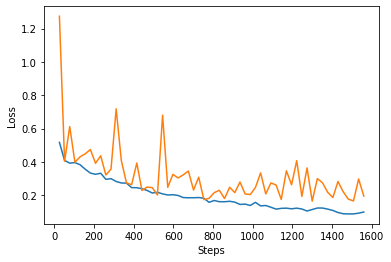

In [ ]:
plt.plot(steps_ls, train_loss_ls)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls)
plt.show()

# Experiment 2: Different Models
1. RGB Model
2. RGB Model + Image Transformation
3. VGG11 with batch normalization (vgg11_bn). Loaded the VGG11 model from pytorch. Source: https://pytorch.org/vision/stable/models.html.

In [ ]:
# RGB Model
model = PA2Net(first_in_channel=3)
summary(model, torch.zeros((1, 3, 32, 32)))

                                  Kernel Shape      Output Shape    Params  \
Layer                                                                        
0_conv1                          [3, 32, 3, 3]   [1, 32, 32, 32]     896.0   
1_norm1                                   [32]   [1, 32, 32, 32]      64.0   
2_conv2                         [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k   
3_norm2                                   [32]   [1, 32, 32, 32]      64.0   
4_pool1                                      -   [1, 32, 16, 16]         -   
5_conv3                         [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k   
6_norm3                                   [64]   [1, 64, 16, 16]     128.0   
7_conv4                        [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
8_norm4                                  [128]  [1, 128, 16, 16]     256.0   
9_conv5                       [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   
10_norm5                                 [256]  [1, 256, 16, 16]

Kernel Shape  ...    Mult-Adds
Layer                                           ...             
0_conv1                          [3, 32, 3, 3]  ...     884736.0
1_norm1                                   [32]  ...         32.0
2_conv2                         [32, 32, 3, 3]  ...    9437184.0
3_norm2                                   [32]  ...         32.0
4_pool1                                      -  ...          NaN
5_conv3                         [32, 64, 3, 3]  ...    4718592.0
6_norm3                                   [64]  ...         64.0
7_conv4                        [64, 128, 3, 3]  ...   18874368.0
8_norm4                                  [128]  ...        128.0
9_conv5                       [128, 256, 3, 3]  ...   75497472.0
10_norm5                                 [256]  ...        256.0
11_conv6                      [256, 512, 3, 3]  ...  301989888.0
12_norm6                                 [512]  ...        512.0
13_pool2                                     -  ...          NaN
14_fully_connected.Linear_0         [512, 512]  ...     262144.0
15_fully_connected.ReLU_1                    -  ...          NaN
16_fully_connected.Dropout_2                 -  ...          NaN
17_fully_connected.Linear_3           [512, 3]  ...       1536.0

[18 rows x 4 columns]

In [ ]:
# Load in RGB datasets
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.ToTensor(),
      ])

dataset_train = FacemaskDataset(train_path, transform=transform_original, rgb=True)
dataset_valid = FacemaskDataset(valid_path, transform=transform_original, rgb=True)
dataset_test = FacemaskDataset(test_path, transform=transform_original, rgb=True)

# Create dataset iterators
bs = 128

train_loader_rgb = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_rgb = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_rgb = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
"""
Test RGB model
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net(first_in_channel=3)
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'RGBNet_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_rgb, valid_loader_rgb, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to RGBNet_best.pt
Epoch [1/40], Step 26, Train Loss: 0.3743, Train Acc: 0.8667, Val Macro Avg: 0.5139, Valid Loss: 0.6600,  Valid Acc: 0.8526
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        63
           1       0.89      0.94      0.91       329
           2       0.00      0.00      0.00        15

    accuracy                           0.85       407
   macro avg       0.51      0.52      0.51       407
weighted avg       0.82      0.85      0.84       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to RGBNet_best.pt
Epoch [2/40], Step 52, Train Loss: 0.2484, Train Acc: 0.9217, Val Macro Avg: 0.5881, Valid Loss: 0.2822,  Valid Acc: 0.9017
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        63
           1       0.94      0.94      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.56      0.62      0.59       407
weighted avg       0.88      0.90      0.89       407




Model saved to RGBNet_best.pt
Epoch [3/40], Step 78, Train Loss: 0.2217, Train Acc: 0.9306, Val Macro Avg: 0.6034, Valid Loss: 0.2655,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        63
           1       0.92      0.98      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.61      0.60      0.60       407
weighted avg       0.89      0.92      0.90       407




Model saved to RGBNet_best.pt
Epoch [4/40], Step 104, Train Loss: 0.2201, Train Acc: 0.9331, Val Macro Avg: 0.6087, Valid Loss: 0.2536,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        63
           1       0.97      0.96      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.58      0.65      0.61       407
weighted avg       0.90      0.93      0.91       407




Epoch [5/40], Step 130, Train Loss: 0.2077, Train Acc: 0.9321, Val Macro Avg: 0.5903, Valid Loss: 0.2661,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.72      0.94      0.81        63
           1       0.96      0.95      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.56      0.63      0.59       407
weighted avg       0.89      0.91      0.90       407




Model saved to RGBNet_best.pt
Epoch [6/40], Step 156, Train Loss: 0.1904, Train Acc: 0.9383, Val Macro Avg: 0.6243, Valid Loss: 0.1881,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        63
           1       0.95      0.97      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.60      0.65      0.62       407
weighted avg       0.90      0.94      0.92       407




Epoch [7/40], Step 182, Train Loss: 0.1782, Train Acc: 0.9423, Val Macro Avg: 0.6060, Valid Loss: 0.2107,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        63
           1       0.96      0.96      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.58      0.64      0.61       407
weighted avg       0.90      0.92      0.91       407




Model saved to RGBNet_best.pt
Epoch [8/40], Step 208, Train Loss: 0.1786, Train Acc: 0.9401, Val Macro Avg: 0.6273, Valid Loss: 0.1860,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        63
           1       0.95      0.98      0.97       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.61      0.64      0.63       407
weighted avg       0.91      0.94      0.92       407




Epoch [9/40], Step 234, Train Loss: 0.1556, Train Acc: 0.9475, Val Macro Avg: 0.6018, Valid Loss: 0.2554,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        63
           1       0.92      0.99      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.62      0.59      0.60       407
weighted avg       0.89      0.92      0.90       407




Model saved to RGBNet_best.pt
Epoch [10/40], Step 260, Train Loss: 0.1414, Train Acc: 0.9549, Val Macro Avg: 0.6600, Valid Loss: 0.1769,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        63
           1       0.96      0.98      0.97       329
           2       0.50      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.77      0.66      0.66       407
weighted avg       0.93      0.94      0.93       407




Model saved to RGBNet_best.pt
Epoch [11/40], Step 286, Train Loss: 0.1256, Train Acc: 0.9592, Val Macro Avg: 0.6904, Valid Loss: 0.1732,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        63
           1       0.96      0.97      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.93      0.68      0.69       407
weighted avg       0.94      0.93      0.92       407




Epoch [12/40], Step 312, Train Loss: 0.1347, Train Acc: 0.9546, Val Macro Avg: 0.6281, Valid Loss: 0.2538,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.92      0.75      0.82        63
           1       0.92      0.99      0.95       329
           2       0.25      0.07      0.11        15

    accuracy                           0.92       407
   macro avg       0.70      0.60      0.63       407
weighted avg       0.90      0.92      0.90       407




Epoch [13/40], Step 338, Train Loss: 0.1226, Train Acc: 0.9632, Val Macro Avg: 0.6899, Valid Loss: 0.1718,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        63
           1       0.96      0.97      0.97       329
           2       0.50      0.13      0.21        15

    accuracy                           0.94       407
   macro avg       0.77      0.68      0.69       407
weighted avg       0.93      0.94      0.93       407




Model saved to RGBNet_best.pt
Epoch [14/40], Step 364, Train Loss: 0.1271, Train Acc: 0.9592, Val Macro Avg: 0.7152, Valid Loss: 0.2811,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        63
           1       0.96      0.92      0.94       329
           2       0.56      0.33      0.42        15

    accuracy                           0.90       407
   macro avg       0.74      0.72      0.72       407
weighted avg       0.91      0.90      0.90       407




Model saved to RGBNet_best.pt
Epoch [15/40], Step 390, Train Loss: 0.1106, Train Acc: 0.9641, Val Macro Avg: 0.7543, Valid Loss: 0.1415,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.97      0.98      0.97       329
           2       0.67      0.27      0.38        15

    accuracy                           0.95       407
   macro avg       0.84      0.73      0.75       407
weighted avg       0.94      0.95      0.94       407




Epoch [16/40], Step 416, Train Loss: 0.1075, Train Acc: 0.9650, Val Macro Avg: 0.7358, Valid Loss: 0.2042,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        63
           1       0.97      0.94      0.96       329
           2       0.38      0.33      0.36        15

    accuracy                           0.93       407
   macro avg       0.73      0.75      0.74       407
weighted avg       0.93      0.93      0.93       407




Model saved to RGBNet_best.pt
Epoch [17/40], Step 442, Train Loss: 0.1000, Train Acc: 0.9653, Val Macro Avg: 0.8354, Valid Loss: 0.1564,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        63
           1       0.98      0.97      0.97       329
           2       0.75      0.60      0.67        15

    accuracy                           0.95       407
   macro avg       0.85      0.83      0.84       407
weighted avg       0.95      0.95      0.95       407




Epoch [18/40], Step 468, Train Loss: 0.1016, Train Acc: 0.9684, Val Macro Avg: 0.7343, Valid Loss: 0.2740,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.92      0.75      0.82        63
           1       0.93      0.99      0.96       329
           2       1.00      0.27      0.42        15

    accuracy                           0.93       407
   macro avg       0.95      0.67      0.73       407
weighted avg       0.93      0.93      0.92       407




Epoch [19/40], Step 494, Train Loss: 0.1119, Train Acc: 0.9598, Val Macro Avg: 0.7102, Valid Loss: 0.2007,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        63
           1       0.95      0.97      0.96       329
           2       0.60      0.20      0.30        15

    accuracy                           0.93       407
   macro avg       0.80      0.69      0.71       407
weighted avg       0.92      0.93      0.92       407




Epoch [20/40], Step 520, Train Loss: 0.0868, Train Acc: 0.9718, Val Macro Avg: 0.7929, Valid Loss: 0.1894,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        63
           1       0.97      0.95      0.96       329
           2       0.70      0.47      0.56        15

    accuracy                           0.93       407
   macro avg       0.82      0.79      0.79       407
weighted avg       0.93      0.93      0.93       407




Epoch [21/40], Step 546, Train Loss: 0.0789, Train Acc: 0.9742, Val Macro Avg: 0.7727, Valid Loss: 0.1483,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        63
           1       0.97      0.97      0.97       329
           2       0.71      0.33      0.45        15

    accuracy                           0.94       407
   macro avg       0.85      0.75      0.77       407
weighted avg       0.94      0.94      0.94       407




Epoch [22/40], Step 572, Train Loss: 0.0910, Train Acc: 0.9714, Val Macro Avg: 0.7168, Valid Loss: 0.1729,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        63
           1       0.96      0.98      0.97       329
           2       0.50      0.20      0.29        15

    accuracy                           0.94       407
   macro avg       0.78      0.69      0.72       407
weighted avg       0.93      0.94      0.93       407




Epoch [23/40], Step 598, Train Loss: 0.0897, Train Acc: 0.9702, Val Macro Avg: 0.7894, Valid Loss: 0.1905,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        63
           1       0.98      0.95      0.96       329
           2       0.57      0.53      0.55        15

    accuracy                           0.93       407
   macro avg       0.78      0.81      0.79       407
weighted avg       0.93      0.93      0.93       407




Epoch [24/40], Step 624, Train Loss: 0.0586, Train Acc: 0.9819, Val Macro Avg: 0.7938, Valid Loss: 0.1511,  Valid Acc: 0.9558
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        63
           1       0.96      0.99      0.98       329
           2       0.83      0.33      0.48        15

    accuracy                           0.96       407
   macro avg       0.91      0.75      0.79       407
weighted avg       0.95      0.96      0.95       407




Epoch [25/40], Step 650, Train Loss: 0.0569, Train Acc: 0.9819, Val Macro Avg: 0.8089, Valid Loss: 0.1566,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        63
           1       0.97      0.97      0.97       329
           2       0.53      0.53      0.53        15

    accuracy                           0.95       407
   macro avg       0.81      0.81      0.81       407
weighted avg       0.95      0.95      0.95       407




Epoch [26/40], Step 676, Train Loss: 0.0695, Train Acc: 0.9751, Val Macro Avg: 0.7933, Valid Loss: 0.2519,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.82      0.87      0.85        63
           1       0.96      0.97      0.96       329
           2       1.00      0.40      0.57        15

    accuracy                           0.93       407
   macro avg       0.93      0.75      0.79       407
weighted avg       0.94      0.93      0.93       407




Epoch [27/40], Step 702, Train Loss: 0.0835, Train Acc: 0.9727, Val Macro Avg: 0.6820, Valid Loss: 0.2848,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        63
           1       0.93      0.99      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.95      0.64      0.68       407
weighted avg       0.93      0.93      0.91       407




Epoch [28/40], Step 728, Train Loss: 0.0678, Train Acc: 0.9788, Val Macro Avg: 0.8197, Valid Loss: 0.1455,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        63
           1       0.97      0.98      0.97       329
           2       0.62      0.53      0.57        15

    accuracy                           0.95       407
   macro avg       0.83      0.81      0.82       407
weighted avg       0.95      0.95      0.95       407




Model saved to RGBNet_best.pt
Epoch [29/40], Step 754, Train Loss: 0.0556, Train Acc: 0.9822, Val Macro Avg: 0.8369, Valid Loss: 0.1616,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        63
           1       0.98      0.97      0.98       329
           2       0.69      0.60      0.64        15

    accuracy                           0.95       407
   macro avg       0.85      0.83      0.84       407
weighted avg       0.95      0.95      0.95       407




Epoch [30/40], Step 780, Train Loss: 0.0572, Train Acc: 0.9819, Val Macro Avg: 0.6593, Valid Loss: 0.3075,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.94      0.98      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.78      0.65      0.66       407
weighted avg       0.92      0.94      0.92       407




Epoch [31/40], Step 806, Train Loss: 0.0572, Train Acc: 0.9797, Val Macro Avg: 0.8220, Valid Loss: 0.1499,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        63
           1       0.98      0.97      0.97       329
           2       0.67      0.53      0.59        15

    accuracy                           0.95       407
   macro avg       0.84      0.81      0.82       407
weighted avg       0.95      0.95      0.95       407




Epoch [32/40], Step 832, Train Loss: 0.0491, Train Acc: 0.9859, Val Macro Avg: 0.7725, Valid Loss: 0.1928,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.96      0.97      0.97       329
           2       0.50      0.40      0.44        15

    accuracy                           0.94       407
   macro avg       0.79      0.76      0.77       407
weighted avg       0.94      0.94      0.94       407




Epoch [33/40], Step 858, Train Loss: 0.0424, Train Acc: 0.9862, Val Macro Avg: 0.7788, Valid Loss: 0.1673,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        63
           1       0.97      0.98      0.97       329
           2       0.71      0.33      0.45        15

    accuracy                           0.95       407
   macro avg       0.85      0.75      0.78       407
weighted avg       0.94      0.95      0.94       407




Epoch [34/40], Step 884, Train Loss: 0.0358, Train Acc: 0.9893, Val Macro Avg: 0.7335, Valid Loss: 0.2301,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        63
           1       0.97      0.98      0.97       329
           2       0.75      0.20      0.32        15

    accuracy                           0.95       407
   macro avg       0.86      0.72      0.73       407
weighted avg       0.94      0.95      0.94       407




Epoch [35/40], Step 910, Train Loss: 0.0447, Train Acc: 0.9843, Val Macro Avg: 0.6281, Valid Loss: 0.3942,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.98      0.73      0.84        63
           1       0.93      1.00      0.96       329
           2       0.11      0.07      0.08        15

    accuracy                           0.92       407
   macro avg       0.67      0.60      0.63       407
weighted avg       0.91      0.92      0.91       407




Model saved to RGBNet_best.pt
Epoch [36/40], Step 936, Train Loss: 0.0525, Train Acc: 0.9816, Val Macro Avg: 0.8401, Valid Loss: 0.2038,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        63
           1       0.98      0.96      0.97       329
           2       0.69      0.60      0.64        15

    accuracy                           0.95       407
   macro avg       0.84      0.84      0.84       407
weighted avg       0.95      0.95      0.95       407




Epoch [37/40], Step 962, Train Loss: 0.0659, Train Acc: 0.9779, Val Macro Avg: 0.7248, Valid Loss: 0.3093,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        63
           1       0.97      0.95      0.96       329
           2       0.50      0.27      0.35        15

    accuracy                           0.93       407
   macro avg       0.75      0.72      0.72       407
weighted avg       0.93      0.93      0.93       407




Model saved to RGBNet_best.pt
Epoch [38/40], Step 988, Train Loss: 0.0475, Train Acc: 0.9850, Val Macro Avg: 0.8459, Valid Loss: 0.1730,  Valid Acc: 0.9582
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        63
           1       0.98      0.98      0.98       329
           2       0.69      0.60      0.64        15

    accuracy                           0.96       407
   macro avg       0.86      0.84      0.85       407
weighted avg       0.96      0.96      0.96       407




Epoch [39/40], Step 1014, Train Loss: 0.0432, Train Acc: 0.9880, Val Macro Avg: 0.7828, Valid Loss: 0.2176,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        63
           1       0.98      0.94      0.96       329
           2       0.43      0.60      0.50        15

    accuracy                           0.93       407
   macro avg       0.75      0.83      0.78       407
weighted avg       0.94      0.93      0.93       407




Epoch [40/40], Step 1040, Train Loss: 0.0316, Train Acc: 0.9889, Val Macro Avg: 0.7273, Valid Loss: 0.2679,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        63
           1       0.96      0.98      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.94       407
   macro avg       0.93      0.70      0.73       407
weighted avg       0.94      0.94      0.93       407

Finished Training
Best validation macro average: 0.8459329716099387
Best validation loss: 0.17299124223452206


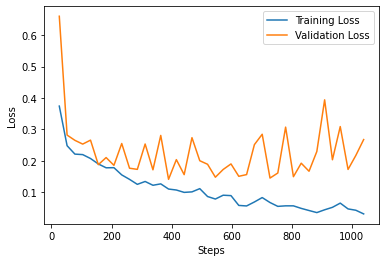

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
"""
Combine image transformations & RGB
"""
# Load in RGB datasets
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform_train_rgb = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(10),
      transforms.ToTensor(), 
      #transforms.Normalize((0.5, ), (0.5, )),
      ])

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.ToTensor(),
      ])

dataset_train = FacemaskDataset(train_path, transform=transform_train_rgb, rgb=True)
dataset_valid = FacemaskDataset(valid_path, transform=transform_original, rgb=True)
dataset_test = FacemaskDataset(test_path, transform=transform_original, rgb=True)

# Create dataset iterators
bs = 128

train_loader_transform_rgb = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_transform_rgb = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_transform_rgb = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net(first_in_channel=3)
num_epochs = 60
criterion = nn.CrossEntropyLoss()
save_path = f'RGBNet_and_transform_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_transform_rgb, valid_loader_transform_rgb, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to RGBNet_and_transform_best.pt
Epoch [1/60], Step 26, Train Loss: 0.3492, Train Acc: 0.8885, Val Macro Avg: 0.5384, Valid Loss: 0.3869,  Valid Acc: 0.8526
              precision    recall  f1-score   support

           0       0.56      0.94      0.70        63
           1       0.95      0.88      0.91       329
           2       0.00      0.00      0.00        15

    accuracy                           0.85       407
   macro avg       0.51      0.60      0.54       407
weighted avg       0.86      0.85      0.85       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to RGBNet_and_transform_best.pt
Epoch [2/60], Step 52, Train Loss: 0.2467, Train Acc: 0.9199, Val Macro Avg: 0.5611, Valid Loss: 0.3584,  Valid Acc: 0.8845
              precision    recall  f1-score   support

           0       0.63      0.90      0.75        63
           1       0.96      0.92      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.88       407
   macro avg       0.53      0.61      0.56       407
weighted avg       0.87      0.88      0.87       407




Model saved to RGBNet_and_transform_best.pt
Epoch [3/60], Step 78, Train Loss: 0.2274, Train Acc: 0.9337, Val Macro Avg: 0.6135, Valid Loss: 0.2753,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.62      0.61      0.61       407
weighted avg       0.89      0.93      0.91       407




Epoch [4/60], Step 104, Train Loss: 0.2093, Train Acc: 0.9328, Val Macro Avg: 0.5872, Valid Loss: 0.2803,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        63
           1       0.97      0.94      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.55      0.64      0.59       407
weighted avg       0.89      0.91      0.90       407




Model saved to RGBNet_and_transform_best.pt
Epoch [5/60], Step 130, Train Loss: 0.1956, Train Acc: 0.9383, Val Macro Avg: 0.6171, Valid Loss: 0.2073,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        63
           1       0.95      0.97      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.59      0.64      0.62       407
weighted avg       0.90      0.93      0.91       407




Model saved to RGBNet_and_transform_best.pt
Epoch [6/60], Step 156, Train Loss: 0.1906, Train Acc: 0.9368, Val Macro Avg: 0.6172, Valid Loss: 0.2134,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        63
           1       0.94      0.98      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.61      0.62      0.62       407
weighted avg       0.90      0.93      0.92       407




Model saved to RGBNet_and_transform_best.pt
Epoch [7/60], Step 182, Train Loss: 0.1938, Train Acc: 0.9337, Val Macro Avg: 0.6181, Valid Loss: 0.2398,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.62      0.62      0.62       407
weighted avg       0.90      0.93      0.92       407




Model saved to RGBNet_and_transform_best.pt
Epoch [8/60], Step 208, Train Loss: 0.1746, Train Acc: 0.9414, Val Macro Avg: 0.6272, Valid Loss: 0.2545,  Valid Acc: 0.9066
              precision    recall  f1-score   support

           0       0.71      0.95      0.82        63
           1       0.96      0.94      0.95       329
           2       0.50      0.07      0.12        15

    accuracy                           0.91       407
   macro avg       0.72      0.65      0.63       407
weighted avg       0.90      0.91      0.90       407




Epoch [9/60], Step 234, Train Loss: 0.1584, Train Acc: 0.9457, Val Macro Avg: 0.6151, Valid Loss: 0.2796,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.62      0.61      0.62       407
weighted avg       0.90      0.93      0.91       407




Model saved to RGBNet_and_transform_best.pt
Epoch [10/60], Step 260, Train Loss: 0.1513, Train Acc: 0.9509, Val Macro Avg: 0.7530, Valid Loss: 0.1752,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        63
           1       0.96      0.98      0.97       329
           2       0.80      0.27      0.40        15

    accuracy                           0.94       407
   macro avg       0.88      0.71      0.75       407
weighted avg       0.94      0.94      0.94       407




Model saved to RGBNet_and_transform_best.pt
Epoch [11/60], Step 286, Train Loss: 0.1474, Train Acc: 0.9543, Val Macro Avg: 0.8274, Valid Loss: 0.1541,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        63
           1       0.97      0.98      0.97       329
           2       0.88      0.47      0.61        15

    accuracy                           0.95       407
   macro avg       0.90      0.79      0.83       407
weighted avg       0.95      0.95      0.95       407




Epoch [12/60], Step 312, Train Loss: 0.1283, Train Acc: 0.9604, Val Macro Avg: 0.7905, Valid Loss: 0.1381,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.96      0.98      0.97       329
           2       0.67      0.40      0.50        15

    accuracy                           0.94       407
   macro avg       0.84      0.76      0.79       407
weighted avg       0.94      0.94      0.94       407




Epoch [13/60], Step 338, Train Loss: 0.1269, Train Acc: 0.9582, Val Macro Avg: 0.6077, Valid Loss: 0.4425,  Valid Acc: 0.8403
              precision    recall  f1-score   support

           0       0.53      0.98      0.69        63
           1       0.97      0.84      0.90       329
           2       1.00      0.13      0.24        15

    accuracy                           0.84       407
   macro avg       0.83      0.65      0.61       407
weighted avg       0.90      0.84      0.84       407




Epoch [14/60], Step 364, Train Loss: 0.1396, Train Acc: 0.9487, Val Macro Avg: 0.6669, Valid Loss: 0.2088,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        63
           1       0.93      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.92       407
   macro avg       0.93      0.63      0.67       407
weighted avg       0.92      0.92      0.91       407




Epoch [15/60], Step 390, Train Loss: 0.1191, Train Acc: 0.9616, Val Macro Avg: 0.7787, Valid Loss: 0.1557,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        63
           1       0.97      0.97      0.97       329
           2       0.83      0.33      0.48        15

    accuracy                           0.94       407
   macro avg       0.88      0.76      0.78       407
weighted avg       0.94      0.94      0.94       407




Epoch [16/60], Step 416, Train Loss: 0.1075, Train Acc: 0.9650, Val Macro Avg: 0.7000, Valid Loss: 0.1771,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        63
           1       0.95      0.98      0.97       329
           2       1.00      0.13      0.24        15

    accuracy                           0.94       407
   macro avg       0.95      0.67      0.70       407
weighted avg       0.94      0.94      0.93       407




Epoch [17/60], Step 442, Train Loss: 0.1048, Train Acc: 0.9656, Val Macro Avg: 0.7399, Valid Loss: 0.1372,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        63
           1       0.96      0.98      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.95       407
   macro avg       0.95      0.71      0.74       407
weighted avg       0.95      0.95      0.94       407




Epoch [18/60], Step 468, Train Loss: 0.1107, Train Acc: 0.9619, Val Macro Avg: 0.6970, Valid Loss: 0.2710,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        63
           1       0.94      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.94       407
   macro avg       0.95      0.66      0.70       407
weighted avg       0.94      0.94      0.92       407




Model saved to RGBNet_and_transform_best.pt
Epoch [19/60], Step 494, Train Loss: 0.1004, Train Acc: 0.9696, Val Macro Avg: 0.8474, Valid Loss: 0.1283,  Valid Acc: 0.9607
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       0.98      0.98      0.98       329
           2       0.80      0.53      0.64        15

    accuracy                           0.96       407
   macro avg       0.89      0.82      0.85       407
weighted avg       0.96      0.96      0.96       407




Model saved to RGBNet_and_transform_best.pt
Epoch [20/60], Step 520, Train Loss: 0.0992, Train Acc: 0.9662, Val Macro Avg: 0.8693, Valid Loss: 0.1159,  Valid Acc: 0.9607
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.98      0.98      0.98       329
           2       0.90      0.60      0.72        15

    accuracy                           0.96       407
   macro avg       0.92      0.84      0.87       407
weighted avg       0.96      0.96      0.96       407




Epoch [21/60], Step 546, Train Loss: 0.0920, Train Acc: 0.9668, Val Macro Avg: 0.8089, Valid Loss: 0.1269,  Valid Acc: 0.9558
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        63
           1       0.97      0.98      0.98       329
           2       0.75      0.40      0.52        15

    accuracy                           0.96       407
   macro avg       0.88      0.77      0.81       407
weighted avg       0.95      0.96      0.95       407




Epoch [22/60], Step 572, Train Loss: 0.1158, Train Acc: 0.9576, Val Macro Avg: 0.7705, Valid Loss: 0.2293,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        63
           1       0.96      0.98      0.97       329
           2       0.50      0.40      0.44        15

    accuracy                           0.94       407
   macro avg       0.80      0.75      0.77       407
weighted avg       0.93      0.94      0.94       407




Epoch [23/60], Step 598, Train Loss: 0.1173, Train Acc: 0.9604, Val Macro Avg: 0.8217, Valid Loss: 0.1475,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        63
           1       0.97      0.97      0.97       329
           2       0.78      0.47      0.58        15

    accuracy                           0.95       407
   macro avg       0.87      0.80      0.82       407
weighted avg       0.95      0.95      0.95       407




Epoch [24/60], Step 624, Train Loss: 0.0985, Train Acc: 0.9684, Val Macro Avg: 0.7500, Valid Loss: 0.1660,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        63
           1       0.96      0.98      0.97       329
           2       0.67      0.27      0.38        15

    accuracy                           0.94       407
   macro avg       0.84      0.72      0.75       407
weighted avg       0.94      0.94      0.94       407




Epoch [25/60], Step 650, Train Loss: 0.0803, Train Acc: 0.9724, Val Macro Avg: 0.7964, Valid Loss: 0.1314,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        63
           1       0.96      0.98      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.95       407
   macro avg       0.95      0.75      0.80       407
weighted avg       0.95      0.95      0.95       407




Epoch [26/60], Step 676, Train Loss: 0.0768, Train Acc: 0.9748, Val Macro Avg: 0.7238, Valid Loss: 0.1959,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.88      0.95      0.92        63
           1       0.96      0.98      0.97       329
           2       0.50      0.20      0.29        15

    accuracy                           0.94       407
   macro avg       0.78      0.71      0.72       407
weighted avg       0.93      0.94      0.94       407




Epoch [27/60], Step 702, Train Loss: 0.0856, Train Acc: 0.9730, Val Macro Avg: 0.7380, Valid Loss: 0.1839,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.96      0.98      0.97       329
           2       1.00      0.20      0.33        15

    accuracy                           0.95       407
   macro avg       0.95      0.71      0.74       407
weighted avg       0.95      0.95      0.94       407




Model saved to RGBNet_and_transform_best.pt
Epoch [28/60], Step 728, Train Loss: 0.0849, Train Acc: 0.9696, Val Macro Avg: 0.8817, Valid Loss: 0.1353,  Valid Acc: 0.9631
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        63
           1       0.98      0.98      0.98       329
           2       1.00      0.60      0.75        15

    accuracy                           0.96       407
   macro avg       0.96      0.84      0.88       407
weighted avg       0.96      0.96      0.96       407




Epoch [29/60], Step 754, Train Loss: 0.0807, Train Acc: 0.9742, Val Macro Avg: 0.7390, Valid Loss: 0.1550,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.96      0.99      0.98       329
           2       1.00      0.20      0.33        15

    accuracy                           0.95       407
   macro avg       0.95      0.71      0.74       407
weighted avg       0.95      0.95      0.94       407




Epoch [30/60], Step 780, Train Loss: 0.0608, Train Acc: 0.9767, Val Macro Avg: 0.8490, Valid Loss: 0.1608,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.98      0.98      0.98       329
           2       0.67      0.67      0.67        15

    accuracy                           0.95       407
   macro avg       0.85      0.85      0.85       407
weighted avg       0.95      0.95      0.95       407




Epoch [31/60], Step 806, Train Loss: 0.0716, Train Acc: 0.9767, Val Macro Avg: 0.6517, Valid Loss: 0.2688,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        63
           1       0.93      1.00      0.96       329
           2       0.33      0.07      0.11        15

    accuracy                           0.93       407
   macro avg       0.74      0.62      0.65       407
weighted avg       0.92      0.93      0.92       407




Epoch [32/60], Step 832, Train Loss: 0.0752, Train Acc: 0.9745, Val Macro Avg: 0.7805, Valid Loss: 0.1712,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        63
           1       0.98      0.96      0.97       329
           2       0.55      0.40      0.46        15

    accuracy                           0.94       407
   macro avg       0.79      0.78      0.78       407
weighted avg       0.94      0.94      0.94       407




Epoch [33/60], Step 858, Train Loss: 0.0732, Train Acc: 0.9767, Val Macro Avg: 0.6215, Valid Loss: 0.3545,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.90      0.71      0.80        63
           1       0.92      0.99      0.95       329
           2       0.50      0.07      0.12        15

    accuracy                           0.91       407
   macro avg       0.77      0.59      0.62       407
weighted avg       0.90      0.91      0.90       407




Epoch [34/60], Step 884, Train Loss: 0.0880, Train Acc: 0.9699, Val Macro Avg: 0.6570, Valid Loss: 0.2638,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        63
           1       0.95      0.98      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.77      0.65      0.66       407
weighted avg       0.92      0.93      0.92       407




Epoch [35/60], Step 910, Train Loss: 0.0705, Train Acc: 0.9770, Val Macro Avg: 0.6868, Valid Loss: 0.2371,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        63
           1       0.94      0.98      0.96       329
           2       0.50      0.13      0.21        15

    accuracy                           0.93       407
   macro avg       0.78      0.66      0.69       407
weighted avg       0.92      0.93      0.92       407




Epoch [36/60], Step 936, Train Loss: 0.0642, Train Acc: 0.9788, Val Macro Avg: 0.8213, Valid Loss: 0.1257,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        63
           1       0.98      0.97      0.98       329
           2       0.56      0.60      0.58        15

    accuracy                           0.95       407
   macro avg       0.81      0.83      0.82       407
weighted avg       0.95      0.95      0.95       407




Epoch [37/60], Step 962, Train Loss: 0.0517, Train Acc: 0.9828, Val Macro Avg: 0.7938, Valid Loss: 0.1808,  Valid Acc: 0.9558
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        63
           1       0.96      0.99      0.98       329
           2       0.83      0.33      0.48        15

    accuracy                           0.96       407
   macro avg       0.91      0.75      0.79       407
weighted avg       0.95      0.96      0.95       407




Epoch [38/60], Step 988, Train Loss: 0.0599, Train Acc: 0.9785, Val Macro Avg: 0.8594, Valid Loss: 0.1146,  Valid Acc: 0.9631
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        63
           1       0.98      0.98      0.98       329
           2       0.89      0.53      0.67        15

    accuracy                           0.96       407
   macro avg       0.92      0.83      0.86       407
weighted avg       0.96      0.96      0.96       407




Epoch [39/60], Step 1014, Train Loss: 0.0586, Train Acc: 0.9791, Val Macro Avg: 0.7539, Valid Loss: 0.1989,  Valid Acc: 0.9582
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        63
           1       0.96      0.99      0.98       329
           2       1.00      0.20      0.33        15

    accuracy                           0.96       407
   macro avg       0.97      0.72      0.75       407
weighted avg       0.96      0.96      0.95       407




Epoch [40/60], Step 1040, Train Loss: 0.0485, Train Acc: 0.9831, Val Macro Avg: 0.8183, Valid Loss: 0.1508,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        63
           1       0.97      0.98      0.97       329
           2       0.70      0.47      0.56        15

    accuracy                           0.95       407
   macro avg       0.86      0.79      0.82       407
weighted avg       0.95      0.95      0.95       407




Epoch [41/60], Step 1066, Train Loss: 0.0519, Train Acc: 0.9825, Val Macro Avg: 0.6999, Valid Loss: 0.2472,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        63
           1       0.95      0.98      0.97       329
           2       0.50      0.13      0.21        15

    accuracy                           0.94       407
   macro avg       0.79      0.68      0.70       407
weighted avg       0.93      0.94      0.93       407




Model saved to RGBNet_and_transform_best.pt
Epoch [42/60], Step 1092, Train Loss: 0.0563, Train Acc: 0.9800, Val Macro Avg: 0.8899, Valid Loss: 0.1553,  Valid Acc: 0.9656
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        63
           1       0.98      0.99      0.98       329
           2       0.75      0.80      0.77        15

    accuracy                           0.97       407
   macro avg       0.89      0.89      0.89       407
weighted avg       0.97      0.97      0.97       407




Epoch [43/60], Step 1118, Train Loss: 0.0642, Train Acc: 0.9757, Val Macro Avg: 0.7638, Valid Loss: 0.3401,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.93      0.83      0.87        63
           1       0.94      0.98      0.96       329
           2       0.71      0.33      0.45        15

    accuracy                           0.94       407
   macro avg       0.86      0.71      0.76       407
weighted avg       0.93      0.94      0.93       407




Epoch [44/60], Step 1144, Train Loss: 0.0793, Train Acc: 0.9767, Val Macro Avg: 0.7960, Valid Loss: 0.1717,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        63
           1       0.96      0.99      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.95       407
   macro avg       0.96      0.75      0.80       407
weighted avg       0.95      0.95      0.95       407




Epoch [45/60], Step 1170, Train Loss: 0.0500, Train Acc: 0.9843, Val Macro Avg: 0.6854, Valid Loss: 0.2483,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        63
           1       0.95      0.96      0.96       329
           2       0.22      0.13      0.17        15

    accuracy                           0.93       407
   macro avg       0.70      0.68      0.69       407
weighted avg       0.92      0.93      0.93       407




Epoch [46/60], Step 1196, Train Loss: 0.0513, Train Acc: 0.9800, Val Macro Avg: 0.7106, Valid Loss: 0.3067,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        63
           1       0.96      0.99      0.97       329
           2       0.67      0.13      0.22        15

    accuracy                           0.95       407
   macro avg       0.85      0.69      0.71       407
weighted avg       0.94      0.95      0.94       407




Epoch [47/60], Step 1222, Train Loss: 0.0373, Train Acc: 0.9874, Val Macro Avg: 0.8335, Valid Loss: 0.1425,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        63
           1       0.97      0.98      0.97       329
           2       0.67      0.53      0.59        15

    accuracy                           0.95       407
   macro avg       0.86      0.82      0.83       407
weighted avg       0.95      0.95      0.95       407




Epoch [48/60], Step 1248, Train Loss: 0.0443, Train Acc: 0.9865, Val Macro Avg: 0.8112, Valid Loss: 0.1714,  Valid Acc: 0.9558
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        63
           1       0.97      0.98      0.97       329
           2       0.75      0.40      0.52        15

    accuracy                           0.96       407
   macro avg       0.88      0.78      0.81       407
weighted avg       0.95      0.96      0.95       407




Epoch [49/60], Step 1274, Train Loss: 0.0477, Train Acc: 0.9831, Val Macro Avg: 0.7739, Valid Loss: 0.2333,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        63
           1       0.97      0.95      0.96       329
           2       0.44      0.53      0.48        15

    accuracy                           0.93       407
   macro avg       0.76      0.79      0.77       407
weighted avg       0.93      0.93      0.93       407




Epoch [50/60], Step 1300, Train Loss: 0.0459, Train Acc: 0.9837, Val Macro Avg: 0.8203, Valid Loss: 0.1769,  Valid Acc: 0.9509
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.96      0.98      0.97       329
           2       0.78      0.47      0.58        15

    accuracy                           0.95       407
   macro avg       0.88      0.78      0.82       407
weighted avg       0.95      0.95      0.95       407




Epoch [51/60], Step 1326, Train Loss: 0.0402, Train Acc: 0.9871, Val Macro Avg: 0.7545, Valid Loss: 0.2728,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        63
           1       0.97      0.97      0.97       329
           2       1.00      0.27      0.42        15

    accuracy                           0.94       407
   macro avg       0.93      0.73      0.75       407
weighted avg       0.94      0.94      0.93       407




Epoch [52/60], Step 1352, Train Loss: 0.0362, Train Acc: 0.9883, Val Macro Avg: 0.8310, Valid Loss: 0.1678,  Valid Acc: 0.9607
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        63
           1       0.97      0.99      0.98       329
           2       0.78      0.47      0.58        15

    accuracy                           0.96       407
   macro avg       0.89      0.80      0.83       407
weighted avg       0.96      0.96      0.96       407




Epoch [53/60], Step 1378, Train Loss: 0.0266, Train Acc: 0.9899, Val Macro Avg: 0.7284, Valid Loss: 0.2930,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        63
           1       0.95      0.99      0.97       329
           2       0.60      0.20      0.30        15

    accuracy                           0.94       407
   macro avg       0.83      0.69      0.73       407
weighted avg       0.93      0.94      0.94       407




Epoch [54/60], Step 1404, Train Loss: 0.0604, Train Acc: 0.9788, Val Macro Avg: 0.7734, Valid Loss: 0.3171,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        63
           1       0.94      0.99      0.97       329
           2       0.71      0.33      0.45        15

    accuracy                           0.94       407
   macro avg       0.87      0.72      0.77       407
weighted avg       0.94      0.94      0.94       407




Epoch [55/60], Step 1430, Train Loss: 0.0729, Train Acc: 0.9754, Val Macro Avg: 0.7983, Valid Loss: 0.1606,  Valid Acc: 0.9533
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       0.96      0.98      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.95       407
   macro avg       0.96      0.75      0.80       407
weighted avg       0.95      0.95      0.95       407




Epoch [56/60], Step 1456, Train Loss: 0.0401, Train Acc: 0.9877, Val Macro Avg: 0.8249, Valid Loss: 0.1279,  Valid Acc: 0.9582
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        63
           1       0.97      0.98      0.98       329
           2       0.70      0.47      0.56        15

    accuracy                           0.96       407
   macro avg       0.87      0.80      0.82       407
weighted avg       0.96      0.96      0.96       407




Epoch [57/60], Step 1482, Train Loss: 0.0262, Train Acc: 0.9923, Val Macro Avg: 0.7807, Valid Loss: 0.2305,  Valid Acc: 0.9582
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        63
           1       0.96      0.99      0.98       329
           2       1.00      0.27      0.42        15

    accuracy                           0.96       407
   macro avg       0.97      0.74      0.78       407
weighted avg       0.96      0.96      0.95       407




Epoch [58/60], Step 1508, Train Loss: 0.0265, Train Acc: 0.9926, Val Macro Avg: 0.7760, Valid Loss: 0.2284,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        63
           1       0.97      0.98      0.97       329
           2       0.71      0.33      0.45        15

    accuracy                           0.95       407
   macro avg       0.85      0.75      0.78       407
weighted avg       0.94      0.95      0.94       407




Epoch [59/60], Step 1534, Train Loss: 0.0437, Train Acc: 0.9856, Val Macro Avg: 0.7316, Valid Loss: 0.2265,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.96      0.98      0.97       329
           2       0.75      0.20      0.32        15

    accuracy                           0.95       407
   macro avg       0.86      0.71      0.73       407
weighted avg       0.94      0.95      0.94       407




Epoch [60/60], Step 1560, Train Loss: 0.0464, Train Acc: 0.9828, Val Macro Avg: 0.7676, Valid Loss: 0.2322,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        63
           1       0.97      0.98      0.97       329
           2       1.00      0.27      0.42        15

    accuracy                           0.95       407
   macro avg       0.94      0.74      0.77       407
weighted avg       0.95      0.95      0.94       407

Finished Training
Best validation macro average: 0.8898703796422129
Best validation loss: 0.15533931090008368


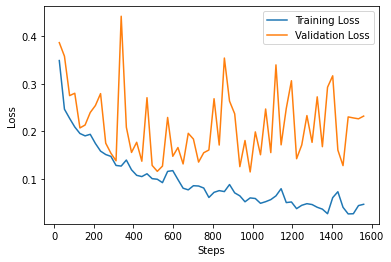

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
"""
VGG11 Pretrained
"""
# Load vgg11 pretrained
pt_vgg11 = models.vgg11_bn(pretrained=True)
# Only train the final fc layers. Freeze the feature extraction layers
for param in pt_vgg11.parameters():
  param.requires_grad = False
# Get the number of ouput features for linear layer
num_ftrs = pt_vgg11.classifier[6].in_features
pt_vgg11.classifier[6] = nn.Linear(num_ftrs,3)
input_size = 224 # This is the input size of vgg11

summary(pt_vgg11, torch.zeros((1, 3, input_size, input_size)))


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



                                Kernel Shape        Output Shape   Params  \
Layer                                                                       
0_features.Conv2d_0            [3, 64, 3, 3]   [1, 64, 224, 224]        -   
1_features.BatchNorm2d_1                [64]   [1, 64, 224, 224]        -   
2_features.ReLU_2                          -   [1, 64, 224, 224]        -   
3_features.MaxPool2d_3                     -   [1, 64, 112, 112]        -   
4_features.Conv2d_4          [64, 128, 3, 3]  [1, 128, 112, 112]        -   
5_features.BatchNorm2d_5               [128]  [1, 128, 112, 112]        -   
6_features.ReLU_6                          -  [1, 128, 112, 112]        -   
7_features.MaxPool2d_7                     -    [1, 128, 56, 56]        -   
8_features.Conv2d_8         [128, 256, 3, 3]    [1, 256, 56, 56]        -   
9_features.BatchNorm2d_9               [256]    [1, 256, 56, 56]        -   
10_features.ReLU_10                        -    [1, 256, 56, 56]        -  

Kernel Shape  ... Mult-Adds
Layer                                         ...          
0_features.Conv2d_0            [3, 64, 3, 3]  ...       NaN
1_features.BatchNorm2d_1                [64]  ...       NaN
2_features.ReLU_2                          -  ...       NaN
3_features.MaxPool2d_3                     -  ...       NaN
4_features.Conv2d_4          [64, 128, 3, 3]  ...       NaN
5_features.BatchNorm2d_5               [128]  ...       NaN
6_features.ReLU_6                          -  ...       NaN
7_features.MaxPool2d_7                     -  ...       NaN
8_features.Conv2d_8         [128, 256, 3, 3]  ...       NaN
9_features.BatchNorm2d_9               [256]  ...       NaN
10_features.ReLU_10                        -  ...       NaN
11_features.Conv2d_11       [256, 256, 3, 3]  ...       NaN
12_features.BatchNorm2d_12             [256]  ...       NaN
13_features.ReLU_13                        -  ...       NaN
14_features.MaxPool2d_14                   -  ...       NaN
15_features.Conv2d_15       [256, 512, 3, 3]  ...       NaN
16_features.BatchNorm2d_16             [512]  ...       NaN
17_features.ReLU_17                        -  ...       NaN
18_features.Conv2d_18       [512, 512, 3, 3]  ...       NaN
19_features.BatchNorm2d_19             [512]  ...       NaN
20_features.ReLU_20                        -  ...       NaN
21_features.MaxPool2d_21                   -  ...       NaN
22_features.Conv2d_22       [512, 512, 3, 3]  ...       NaN
23_features.BatchNorm2d_23             [512]  ...       NaN
24_features.ReLU_24                        -  ...       NaN
25_features.Conv2d_25       [512, 512, 3, 3]  ...       NaN
26_features.BatchNorm2d_26             [512]  ...       NaN
27_features.ReLU_27                        -  ...       NaN
28_features.MaxPool2d_28                   -  ...       NaN
29_avgpool                                 -  ...       NaN
30_classifier.Linear_0         [25088, 4096]  ...       NaN
31_classifier.ReLU_1                       -  ...       NaN
32_classifier.Dropout_2                    -  ...       NaN
33_classifier.Linear_3          [4096, 4096]  ...       NaN
34_classifier.ReLU_4                       -  ...       NaN
35_classifier.Dropout_5                    -  ...       NaN
36_classifier.Linear_6             [4096, 3]  ...   12288.0

[37 rows x 4 columns]

In [ ]:
# Make the dataset and iterators for vgg11 model
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((input_size,input_size)),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      ])

dataset_train = FacemaskDataset(train_path, transform=transform_original, rgb=True)
dataset_valid = FacemaskDataset(valid_path, transform=transform_original, rgb=True)
dataset_test = FacemaskDataset(test_path, transform=transform_original, rgb=True)

# Create dataset iterators
bs = 128

train_loader_vgg = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_vgg = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_vgg = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Train the vgg11 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = pt_vgg11
num_epochs = 80
criterion = nn.CrossEntropyLoss()
save_path = f'vgg11_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.01)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_vgg, valid_loader_vgg, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to vgg11_best.pt
Epoch [1/80], Step 26, Train Loss: 1.1402, Train Acc: 0.7928, Val Macro Avg: 0.4311, Valid Loss: 0.7522,  Valid Acc: 0.7125
              precision    recall  f1-score   support

           0       0.35      0.76      0.48        63
           1       0.91      0.74      0.81       329
           2       0.00      0.00      0.00        15

    accuracy                           0.71       407
   macro avg       0.42      0.50      0.43       407
weighted avg       0.79      0.71      0.73       407




Model saved to vgg11_best.pt
Epoch [2/80], Step 52, Train Loss: 0.4012, Train Acc: 0.8686, Val Macro Avg: 0.6199, Valid Loss: 0.3027,  Valid Acc: 0.8968
              precision    recall  f1-score   support

           0       0.71      0.90      0.80        63
           1       0.94      0.93      0.94       329
           2       1.00      0.07      0.12        15

    accuracy                           0.90       407
   macro avg       0.88      0.63      0.62       407
weighted avg       0.91      0.90      0.89       407




Model saved to vgg11_best.pt
Epoch [3/80], Step 78, Train Loss: 0.3922, Train Acc: 0.8698, Val Macro Avg: 0.7000, Valid Loss: 0.2707,  Valid Acc: 0.9066
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        63
           1       0.97      0.93      0.95       329
           2       0.44      0.27      0.33        15

    accuracy                           0.91       407
   macro avg       0.71      0.71      0.70       407
weighted avg       0.91      0.91      0.90       407




Epoch [4/80], Step 104, Train Loss: 0.3252, Train Acc: 0.8861, Val Macro Avg: 0.6668, Valid Loss: 0.2488,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        63
           1       0.93      0.98      0.95       329
           2       0.50      0.13      0.21        15

    accuracy                           0.92       407
   macro avg       0.77      0.64      0.67       407
weighted avg       0.91      0.92      0.91       407




Epoch [5/80], Step 130, Train Loss: 0.3834, Train Acc: 0.8772, Val Macro Avg: 0.6516, Valid Loss: 0.4544,  Valid Acc: 0.8354
              precision    recall  f1-score   support

           0       0.51      0.98      0.67        63
           1       0.98      0.83      0.90       329
           2       0.67      0.27      0.38        15

    accuracy                           0.84       407
   macro avg       0.72      0.69      0.65       407
weighted avg       0.89      0.84      0.85       407




Model saved to vgg11_best.pt
Epoch [6/80], Step 156, Train Loss: 0.3988, Train Acc: 0.8707, Val Macro Avg: 0.7158, Valid Loss: 0.2270,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        63
           1       0.96      0.96      0.96       329
           2       0.75      0.20      0.32        15

    accuracy                           0.93       407
   macro avg       0.84      0.70      0.72       407
weighted avg       0.93      0.93      0.92       407




Epoch [7/80], Step 182, Train Loss: 0.3457, Train Acc: 0.8849, Val Macro Avg: 0.6825, Valid Loss: 0.2521,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        63
           1       0.96      0.95      0.95       329
           2       0.27      0.20      0.23        15

    accuracy                           0.91       407
   macro avg       0.68      0.69      0.68       407
weighted avg       0.91      0.91      0.91       407




Epoch [8/80], Step 208, Train Loss: 0.3827, Train Acc: 0.8833, Val Macro Avg: 0.6957, Valid Loss: 0.3052,  Valid Acc: 0.8968
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        63
           1       0.96      0.91      0.94       329
           2       0.50      0.27      0.35        15

    accuracy                           0.90       407
   macro avg       0.72      0.71      0.70       407
weighted avg       0.91      0.90      0.90       407




Epoch [9/80], Step 234, Train Loss: 0.4046, Train Acc: 0.8784, Val Macro Avg: 0.6559, Valid Loss: 0.3026,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        63
           1       0.94      0.98      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.78      0.64      0.66       407
weighted avg       0.92      0.93      0.92       407




Epoch [10/80], Step 260, Train Loss: 0.3587, Train Acc: 0.8861, Val Macro Avg: 0.6078, Valid Loss: 0.3066,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        63
           1       0.94      0.97      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.60      0.62      0.61       407
weighted avg       0.89      0.92      0.91       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [11/80], Step 286, Train Loss: 0.3766, Train Acc: 0.8870, Val Macro Avg: 0.5843, Valid Loss: 0.3699,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       0.75      0.87      0.81        63
           1       0.94      0.95      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.56      0.61      0.58       407
weighted avg       0.87      0.90      0.89       407




Epoch [12/80], Step 312, Train Loss: 0.4161, Train Acc: 0.8784, Val Macro Avg: 0.6706, Valid Loss: 0.3402,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        63
           1       0.96      0.95      0.95       329
           2       0.67      0.13      0.22        15

    accuracy                           0.92       407
   macro avg       0.79      0.67      0.67       407
weighted avg       0.92      0.92      0.91       407




Epoch [13/80], Step 338, Train Loss: 0.3747, Train Acc: 0.8935, Val Macro Avg: 0.7004, Valid Loss: 0.2939,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        63
           1       0.94      0.99      0.97       329
           2       1.00      0.13      0.24        15

    accuracy                           0.94       407
   macro avg       0.96      0.66      0.70       407
weighted avg       0.94      0.94      0.93       407




Model saved to vgg11_best.pt
Epoch [14/80], Step 364, Train Loss: 0.3764, Train Acc: 0.8935, Val Macro Avg: 0.7452, Valid Loss: 0.2801,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        63
           1       0.96      0.97      0.96       329
           2       0.67      0.27      0.38        15

    accuracy                           0.94       407
   macro avg       0.83      0.72      0.75       407
weighted avg       0.93      0.94      0.93       407




Epoch [15/80], Step 390, Train Loss: 0.3538, Train Acc: 0.8919, Val Macro Avg: 0.6665, Valid Loss: 0.3827,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        63
           1       0.92      0.99      0.95       329
           2       1.00      0.13      0.24        15

    accuracy                           0.92       407
   macro avg       0.95      0.61      0.67       407
weighted avg       0.92      0.92      0.90       407




Epoch [16/80], Step 416, Train Loss: 0.3300, Train Acc: 0.9008, Val Macro Avg: 0.6723, Valid Loss: 0.3067,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       0.95      0.99      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.95       407
   macro avg       0.95      0.66      0.67       407
weighted avg       0.95      0.95      0.93       407




Epoch [17/80], Step 442, Train Loss: 0.3419, Train Acc: 0.8925, Val Macro Avg: 0.6472, Valid Loss: 0.3716,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        63
           1       0.93      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.94      0.63      0.65       407
weighted avg       0.93      0.93      0.91       407




Epoch [18/80], Step 468, Train Loss: 0.3552, Train Acc: 0.8916, Val Macro Avg: 0.6547, Valid Loss: 0.3226,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.98      0.79      0.88        63
           1       0.93      1.00      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.97      0.62      0.65       407
weighted avg       0.94      0.93      0.92       407




Epoch [19/80], Step 494, Train Loss: 0.3664, Train Acc: 0.8968, Val Macro Avg: 0.6587, Valid Loss: 0.3435,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        63
           1       0.96      0.97      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.93      0.66      0.66       407
weighted avg       0.94      0.93      0.92       407




Epoch [20/80], Step 520, Train Loss: 0.3701, Train Acc: 0.8882, Val Macro Avg: 0.6580, Valid Loss: 0.3044,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        63
           1       0.95      0.97      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.77      0.66      0.66       407
weighted avg       0.92      0.93      0.92       407




Epoch [21/80], Step 546, Train Loss: 0.3383, Train Acc: 0.8975, Val Macro Avg: 0.6352, Valid Loss: 0.4281,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.98      0.71      0.83        63
           1       0.91      1.00      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.96      0.59      0.64       407
weighted avg       0.93      0.92      0.90       407




Epoch [22/80], Step 572, Train Loss: 0.3193, Train Acc: 0.8971, Val Macro Avg: 0.6362, Valid Loss: 0.4135,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.96      0.73      0.83        63
           1       0.92      1.00      0.95       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.96      0.60      0.64       407
weighted avg       0.93      0.92      0.90       407




Epoch [23/80], Step 598, Train Loss: 0.3803, Train Acc: 0.8932, Val Macro Avg: 0.6173, Valid Loss: 0.3177,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.98      0.81      0.89        63
           1       0.93      1.00      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.64      0.60      0.62       407
weighted avg       0.91      0.93      0.92       407




Epoch [24/80], Step 624, Train Loss: 0.3780, Train Acc: 0.8975, Val Macro Avg: 0.6128, Valid Loss: 0.3975,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        63
           1       0.95      0.97      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.60      0.63      0.61       407
weighted avg       0.90      0.93      0.91       407




Epoch [25/80], Step 650, Train Loss: 0.3679, Train Acc: 0.8910, Val Macro Avg: 0.5806, Valid Loss: 0.5155,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.98      0.67      0.79        63
           1       0.90      1.00      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.63      0.56      0.58       407
weighted avg       0.88      0.91      0.89       407




Epoch [26/80], Step 676, Train Loss: 0.4486, Train Acc: 0.8876, Val Macro Avg: 0.6300, Valid Loss: 0.3480,  Valid Acc: 0.9066
              precision    recall  f1-score   support

           0       0.93      0.63      0.75        63
           1       0.92      0.99      0.95       329
           2       0.29      0.13      0.18        15

    accuracy                           0.91       407
   macro avg       0.71      0.59      0.63       407
weighted avg       0.89      0.91      0.89       407




Epoch [27/80], Step 702, Train Loss: 0.3975, Train Acc: 0.8892, Val Macro Avg: 0.5601, Valid Loss: 0.5416,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.95      0.60      0.74        63
           1       0.89      1.00      0.94       329
           2       0.00      0.00      0.00        15

    accuracy                           0.90       407
   macro avg       0.61      0.53      0.56       407
weighted avg       0.87      0.90      0.88       407




Epoch [28/80], Step 728, Train Loss: 0.4938, Train Acc: 0.8858, Val Macro Avg: 0.6211, Valid Loss: 0.4374,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        63
           1       0.93      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.63      0.62      0.62       407
weighted avg       0.90      0.94      0.92       407




Epoch [29/80], Step 754, Train Loss: 0.4025, Train Acc: 0.8932, Val Macro Avg: 0.5764, Valid Loss: 0.6955,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.98      0.65      0.78        63
           1       0.90      1.00      0.95       329
           2       0.00      0.00      0.00        15

    accuracy                           0.91       407
   macro avg       0.63      0.55      0.58       407
weighted avg       0.88      0.91      0.89       407




Epoch [30/80], Step 780, Train Loss: 0.4152, Train Acc: 0.8925, Val Macro Avg: 0.6686, Valid Loss: 0.3851,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        63
           1       0.95      0.99      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.96      0.65      0.67       407
weighted avg       0.95      0.94      0.93       407




Epoch [31/80], Step 806, Train Loss: 0.3790, Train Acc: 0.9014, Val Macro Avg: 0.6938, Valid Loss: 0.3588,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        63
           1       0.96      0.96      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.92      0.69      0.69       407
weighted avg       0.94      0.93      0.92       407




Epoch [32/80], Step 832, Train Loss: 0.4132, Train Acc: 0.8962, Val Macro Avg: 0.6599, Valid Loss: 0.3831,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        63
           1       0.95      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.94      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [33/80], Step 858, Train Loss: 0.3697, Train Acc: 0.9021, Val Macro Avg: 0.6149, Valid Loss: 0.5416,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.95      0.83      0.88        63
           1       0.93      1.00      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.63      0.61      0.61       407
weighted avg       0.90      0.93      0.92       407




Epoch [34/80], Step 884, Train Loss: 0.4047, Train Acc: 0.9014, Val Macro Avg: 0.6623, Valid Loss: 0.4446,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.94      0.99      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [35/80], Step 910, Train Loss: 0.4256, Train Acc: 0.8962, Val Macro Avg: 0.7167, Valid Loss: 0.3311,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        63
           1       0.95      0.99      0.97       329
           2       0.50      0.20      0.29        15

    accuracy                           0.94       407
   macro avg       0.79      0.69      0.72       407
weighted avg       0.93      0.94      0.93       407




Epoch [36/80], Step 936, Train Loss: 0.4334, Train Acc: 0.8861, Val Macro Avg: 0.6594, Valid Loss: 0.4213,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.94      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [37/80], Step 962, Train Loss: 0.3719, Train Acc: 0.9067, Val Macro Avg: 0.6477, Valid Loss: 0.4459,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        63
           1       0.93      0.99      0.96       329
           2       0.33      0.07      0.11        15

    accuracy                           0.93       407
   macro avg       0.74      0.62      0.65       407
weighted avg       0.91      0.93      0.92       407




Epoch [38/80], Step 988, Train Loss: 0.4160, Train Acc: 0.8947, Val Macro Avg: 0.6567, Valid Loss: 0.4341,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        63
           1       0.93      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.95      0.63      0.66       407
weighted avg       0.94      0.93      0.92       407




Epoch [39/80], Step 1014, Train Loss: 0.3626, Train Acc: 0.9030, Val Macro Avg: 0.6432, Valid Loss: 0.4976,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.98      0.75      0.85        63
           1       0.92      1.00      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.97      0.60      0.64       407
weighted avg       0.93      0.93      0.91       407




Epoch [40/80], Step 1040, Train Loss: 0.4045, Train Acc: 0.8962, Val Macro Avg: 0.6743, Valid Loss: 0.3910,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        63
           1       0.95      0.99      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.95       407
   macro avg       0.96      0.66      0.67       407
weighted avg       0.95      0.95      0.93       407




Epoch [41/80], Step 1066, Train Loss: 0.4207, Train Acc: 0.8882, Val Macro Avg: 0.6879, Valid Loss: 0.4077,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        63
           1       0.94      0.98      0.96       329
           2       0.67      0.13      0.22        15

    accuracy                           0.93       407
   macro avg       0.83      0.67      0.69       407
weighted avg       0.92      0.93      0.92       407




Epoch [42/80], Step 1092, Train Loss: 0.4074, Train Acc: 0.8975, Val Macro Avg: 0.6603, Valid Loss: 0.4578,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        63
           1       0.95      0.98      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.78      0.66      0.66       407
weighted avg       0.92      0.94      0.92       407




Epoch [43/80], Step 1118, Train Loss: 0.3994, Train Acc: 0.8925, Val Macro Avg: 0.6245, Valid Loss: 0.4711,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.95      0.99      0.97       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.62      0.63      0.62       407
weighted avg       0.91      0.94      0.92       407




Epoch [44/80], Step 1144, Train Loss: 0.4449, Train Acc: 0.8852, Val Macro Avg: 0.6642, Valid Loss: 0.4137,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        63
           1       0.94      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [45/80], Step 1170, Train Loss: 0.4738, Train Acc: 0.8852, Val Macro Avg: 0.6216, Valid Loss: 0.4133,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        63
           1       0.95      0.98      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.61      0.64      0.62       407
weighted avg       0.90      0.94      0.92       407




Epoch [46/80], Step 1196, Train Loss: 0.3939, Train Acc: 0.8996, Val Macro Avg: 0.6487, Valid Loss: 0.4776,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        63
           1       0.93      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.96      0.62      0.65       407
weighted avg       0.93      0.93      0.91       407




Epoch [47/80], Step 1222, Train Loss: 0.4470, Train Acc: 0.8984, Val Macro Avg: 0.6773, Valid Loss: 0.4310,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.94      0.78      0.85        63
           1       0.93      0.99      0.96       329
           2       0.67      0.13      0.22        15

    accuracy                           0.93       407
   macro avg       0.85      0.63      0.68       407
weighted avg       0.92      0.93      0.91       407




Epoch [48/80], Step 1248, Train Loss: 0.4308, Train Acc: 0.8901, Val Macro Avg: 0.6869, Valid Loss: 0.3269,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        63
           1       0.95      0.97      0.96       329
           2       0.50      0.13      0.21        15

    accuracy                           0.93       407
   macro avg       0.77      0.67      0.69       407
weighted avg       0.92      0.93      0.92       407




Epoch [49/80], Step 1274, Train Loss: 0.4433, Train Acc: 0.8944, Val Macro Avg: 0.7009, Valid Loss: 0.3093,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        63
           1       0.95      0.98      0.97       329
           2       0.40      0.13      0.20        15

    accuracy                           0.94       407
   macro avg       0.77      0.68      0.70       407
weighted avg       0.93      0.94      0.93       407




Epoch [50/80], Step 1300, Train Loss: 0.4695, Train Acc: 0.8968, Val Macro Avg: 0.6621, Valid Loss: 0.4312,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.98      0.83      0.90        63
           1       0.93      1.00      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.97      0.63      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [51/80], Step 1326, Train Loss: 0.3691, Train Acc: 0.9039, Val Macro Avg: 0.6255, Valid Loss: 0.4093,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        63
           1       0.94      0.99      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.62      0.63      0.63       407
weighted avg       0.90      0.94      0.92       407




Epoch [52/80], Step 1352, Train Loss: 0.4334, Train Acc: 0.8996, Val Macro Avg: 0.6833, Valid Loss: 0.3459,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        63
           1       0.94      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.94      0.65      0.68       407
weighted avg       0.93      0.93      0.92       407




Epoch [53/80], Step 1378, Train Loss: 0.4929, Train Acc: 0.8925, Val Macro Avg: 0.6133, Valid Loss: 0.5256,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        63
           1       0.93      1.00      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.93       407
   macro avg       0.63      0.60      0.61       407
weighted avg       0.90      0.93      0.91       407




Epoch [54/80], Step 1404, Train Loss: 0.4289, Train Acc: 0.8950, Val Macro Avg: 0.6225, Valid Loss: 0.4980,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.94      0.98      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.94       407
   macro avg       0.62      0.63      0.62       407
weighted avg       0.90      0.94      0.92       407




Epoch [55/80], Step 1430, Train Loss: 0.5279, Train Acc: 0.8861, Val Macro Avg: 0.5607, Valid Loss: 0.7342,  Valid Acc: 0.8845
              precision    recall  f1-score   support

           0       0.97      0.48      0.64        63
           1       0.88      1.00      0.94       329
           2       0.25      0.07      0.11        15

    accuracy                           0.88       407
   macro avg       0.70      0.51      0.56       407
weighted avg       0.87      0.88      0.86       407




Epoch [56/80], Step 1456, Train Loss: 0.5511, Train Acc: 0.8781, Val Macro Avg: 0.6067, Valid Loss: 0.5701,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        63
           1       0.94      0.97      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.59      0.62      0.61       407
weighted avg       0.89      0.92      0.91       407




Epoch [57/80], Step 1482, Train Loss: 0.4326, Train Acc: 0.9005, Val Macro Avg: 0.6459, Valid Loss: 0.5629,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        63
           1       0.93      1.00      0.96       329
           2       0.50      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.80      0.61      0.65       407
weighted avg       0.92      0.93      0.91       407




Epoch [58/80], Step 1508, Train Loss: 0.3978, Train Acc: 0.9054, Val Macro Avg: 0.6613, Valid Loss: 0.4601,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [59/80], Step 1534, Train Loss: 0.4502, Train Acc: 0.8950, Val Macro Avg: 0.6531, Valid Loss: 0.5364,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.94      0.64      0.65       407
weighted avg       0.93      0.93      0.92       407




Epoch [60/80], Step 1560, Train Loss: 0.4176, Train Acc: 0.8993, Val Macro Avg: 0.7096, Valid Loss: 0.3534,  Valid Acc: 0.9484
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       0.96      0.99      0.97       329
           2       1.00      0.13      0.24        15

    accuracy                           0.95       407
   macro avg       0.95      0.69      0.71       407
weighted avg       0.95      0.95      0.94       407




Epoch [61/80], Step 1586, Train Loss: 0.3610, Train Acc: 0.9076, Val Macro Avg: 0.6343, Valid Loss: 0.5176,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.92      0.75      0.82        63
           1       0.92      0.99      0.95       329
           2       1.00      0.07      0.12        15

    accuracy                           0.92       407
   macro avg       0.95      0.60      0.63       407
weighted avg       0.92      0.92      0.90       407




Epoch [62/80], Step 1612, Train Loss: 0.4803, Train Acc: 0.8925, Val Macro Avg: 0.6556, Valid Loss: 0.4024,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.94      0.64      0.66       407
weighted avg       0.93      0.93      0.92       407




Epoch [63/80], Step 1638, Train Loss: 0.4231, Train Acc: 0.8999, Val Macro Avg: 0.6854, Valid Loss: 0.3979,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        63
           1       0.96      0.96      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.93       407
   macro avg       0.92      0.68      0.69       407
weighted avg       0.93      0.93      0.92       407




Epoch [64/80], Step 1664, Train Loss: 0.4370, Train Acc: 0.8941, Val Macro Avg: 0.6651, Valid Loss: 0.4539,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        63
           1       0.95      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.66      0.67       407
weighted avg       0.94      0.94      0.92       407




Epoch [65/80], Step 1690, Train Loss: 0.4289, Train Acc: 0.9005, Val Macro Avg: 0.6208, Valid Loss: 0.5657,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.98      0.67      0.79        63
           1       0.91      1.00      0.95       329
           2       0.50      0.07      0.12        15

    accuracy                           0.91       407
   macro avg       0.80      0.58      0.62       407
weighted avg       0.90      0.91      0.90       407




Epoch [66/80], Step 1716, Train Loss: 0.4723, Train Acc: 0.8916, Val Macro Avg: 0.6678, Valid Loss: 0.4092,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        63
           1       0.94      1.00      0.97       329
           2       0.50      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.80      0.65      0.67       407
weighted avg       0.93      0.94      0.93       407




Epoch [67/80], Step 1742, Train Loss: 0.4029, Train Acc: 0.9091, Val Macro Avg: 0.6732, Valid Loss: 0.4614,  Valid Acc: 0.9459
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        63
           1       0.94      1.00      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.95       407
   macro avg       0.97      0.65      0.67       407
weighted avg       0.95      0.95      0.93       407




Epoch [68/80], Step 1768, Train Loss: 0.4364, Train Acc: 0.8965, Val Macro Avg: 0.6680, Valid Loss: 0.3850,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        63
           1       0.95      0.98      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.66      0.67       407
weighted avg       0.94      0.94      0.93       407




Epoch [69/80], Step 1794, Train Loss: 0.4643, Train Acc: 0.8904, Val Macro Avg: 0.6661, Valid Loss: 0.3476,  Valid Acc: 0.9435
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        63
           1       0.95      1.00      0.97       329
           2       0.33      0.07      0.11        15

    accuracy                           0.94       407
   macro avg       0.75      0.65      0.67       407
weighted avg       0.93      0.94      0.93       407




Epoch [70/80], Step 1820, Train Loss: 0.4198, Train Acc: 0.9021, Val Macro Avg: 0.6647, Valid Loss: 0.4544,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [71/80], Step 1846, Train Loss: 0.4680, Train Acc: 0.8944, Val Macro Avg: 0.6560, Valid Loss: 0.5421,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.95      0.83      0.88        63
           1       0.93      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.96      0.63      0.66       407
weighted avg       0.94      0.93      0.92       407




Epoch [72/80], Step 1872, Train Loss: 0.4484, Train Acc: 0.9048, Val Macro Avg: 0.5985, Valid Loss: 0.5305,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.96      0.75      0.84        63
           1       0.92      1.00      0.96       329
           2       0.00      0.00      0.00        15

    accuracy                           0.92       407
   macro avg       0.63      0.58      0.60       407
weighted avg       0.89      0.92      0.90       407




Epoch [73/80], Step 1898, Train Loss: 0.4854, Train Acc: 0.8987, Val Macro Avg: 0.6956, Valid Loss: 0.5214,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        63
           1       0.94      0.98      0.96       329
           2       1.00      0.13      0.24        15

    accuracy                           0.94       407
   macro avg       0.94      0.67      0.70       407
weighted avg       0.94      0.94      0.92       407




Epoch [74/80], Step 1924, Train Loss: 0.4093, Train Acc: 0.8987, Val Macro Avg: 0.6977, Valid Loss: 0.4052,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        63
           1       0.95      0.98      0.97       329
           2       1.00      0.13      0.24        15

    accuracy                           0.94       407
   macro avg       0.94      0.68      0.70       407
weighted avg       0.94      0.94      0.93       407




Epoch [75/80], Step 1950, Train Loss: 0.5087, Train Acc: 0.8919, Val Macro Avg: 0.6531, Valid Loss: 0.4687,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.94      0.64      0.65       407
weighted avg       0.93      0.93      0.92       407




Epoch [76/80], Step 1976, Train Loss: 0.4143, Train Acc: 0.9057, Val Macro Avg: 0.6628, Valid Loss: 0.4462,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        63
           1       0.95      0.98      0.97       329
           2       1.00      0.07      0.12        15

    accuracy                           0.94       407
   macro avg       0.95      0.65      0.66       407
weighted avg       0.94      0.94      0.92       407




Epoch [77/80], Step 2002, Train Loss: 0.4573, Train Acc: 0.8965, Val Macro Avg: 0.6475, Valid Loss: 0.5999,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        63
           1       0.93      0.99      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.95      0.62      0.65       407
weighted avg       0.93      0.93      0.91       407




Epoch [78/80], Step 2028, Train Loss: 0.4257, Train Acc: 0.8978, Val Macro Avg: 0.6510, Valid Loss: 0.4252,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        63
           1       0.93      0.98      0.96       329
           2       0.33      0.07      0.11        15

    accuracy                           0.93       407
   macro avg       0.73      0.63      0.65       407
weighted avg       0.91      0.93      0.92       407




Epoch [79/80], Step 2054, Train Loss: 0.4254, Train Acc: 0.8996, Val Macro Avg: 0.6560, Valid Loss: 0.5396,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        63
           1       0.94      0.98      0.96       329
           2       1.00      0.07      0.12        15

    accuracy                           0.93       407
   macro avg       0.94      0.64      0.66       407
weighted avg       0.94      0.93      0.92       407




Epoch [80/80], Step 2080, Train Loss: 0.5386, Train Acc: 0.8879, Val Macro Avg: 0.6240, Valid Loss: 0.6209,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.96      0.68      0.80        63
           1       0.91      1.00      0.95       329
           2       1.00      0.07      0.12        15

    accuracy                           0.91       407
   macro avg       0.95      0.58      0.62       407
weighted avg       0.92      0.91      0.90       407

Finished Training
Best validation macro average: 0.7451842275371687
Best validation loss: 0.2800540488228957


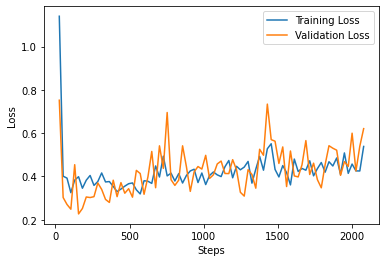

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

# Experiment 3: Fix Class Imablanced
1. Weight Punishment
2. Oversampling
3. Undersampling



In [ ]:
"""
Test by putting weights into loss function
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# weight equals 1/class size
# smaller class freq -> bigger punishment when wrong
weight = torch.tensor([1/717, 1/3232, 1/123]).to(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss(weight=weight)
save_path = f'pa2net_weighted_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_weighted_best.pt
Epoch [1/40], Step 26, Train Loss: 1.0309, Train Acc: 0.5573, Val Macro Avg: 0.2913, Valid Loss: 1.3782,  Valid Acc: 0.3980
              precision    recall  f1-score   support

           0       0.21      0.97      0.35        63
           1       0.95      0.30      0.46       329
           2       0.06      0.07      0.06        15

    accuracy                           0.40       407
   macro avg       0.41      0.45      0.29       407
weighted avg       0.81      0.40      0.43       407




Model saved to pa2net_weighted_best.pt
Epoch [2/40], Step 52, Train Loss: 0.9340, Train Acc: 0.5901, Val Macro Avg: 0.5194, Valid Loss: 0.6242,  Valid Acc: 0.8403
              precision    recall  f1-score   support

           0       0.68      0.33      0.45        63
           1       0.86      0.97      0.91       329
           2       0.40      0.13      0.20        15

    accuracy                           0.84       407
   macro avg       0.65      0.48      0.52       407
weighted avg       0.81      0.84      0.81       407




Model saved to pa2net_weighted_best.pt
Epoch [3/40], Step 78, Train Loss: 0.8486, Train Acc: 0.6727, Val Macro Avg: 0.5400, Valid Loss: 0.5824,  Valid Acc: 0.8034
              precision    recall  f1-score   support

           0       0.63      0.52      0.57        63
           1       0.92      0.88      0.90       329
           2       0.10      0.27      0.15        15

    accuracy                           0.80       407
   macro avg       0.55      0.56      0.54       407
weighted avg       0.85      0.80      0.82       407




Model saved to pa2net_weighted_best.pt
Epoch [4/40], Step 104, Train Loss: 0.8431, Train Acc: 0.6801, Val Macro Avg: 0.5448, Valid Loss: 0.5511,  Valid Acc: 0.7912
              precision    recall  f1-score   support

           0       0.46      0.83      0.59        63
           1       0.94      0.81      0.87       329
           2       0.25      0.13      0.17        15

    accuracy                           0.79       407
   macro avg       0.55      0.59      0.54       407
weighted avg       0.84      0.79      0.80       407




Epoch [5/40], Step 130, Train Loss: 0.7028, Train Acc: 0.7344, Val Macro Avg: 0.4409, Valid Loss: 1.1543,  Valid Acc: 0.4767
              precision    recall  f1-score   support

           0       0.66      0.52      0.58        63
           1       0.97      0.45      0.61       329
           2       0.07      0.93      0.13        15

    accuracy                           0.48       407
   macro avg       0.57      0.63      0.44       407
weighted avg       0.89      0.48      0.59       407




Model saved to pa2net_weighted_best.pt
Epoch [6/40], Step 156, Train Loss: 0.6902, Train Acc: 0.7452, Val Macro Avg: 0.6261, Valid Loss: 0.4436,  Valid Acc: 0.8256
              precision    recall  f1-score   support

           0       0.56      0.79      0.66        63
           1       0.95      0.85      0.90       329
           2       0.27      0.40      0.32        15

    accuracy                           0.83       407
   macro avg       0.59      0.68      0.63       407
weighted avg       0.86      0.83      0.84       407




Epoch [7/40], Step 182, Train Loss: 0.6651, Train Acc: 0.6951, Val Macro Avg: 0.6072, Valid Loss: 0.5152,  Valid Acc: 0.8108
              precision    recall  f1-score   support

           0       0.66      0.62      0.64        63
           1       0.94      0.86      0.90       329
           2       0.19      0.60      0.29        15

    accuracy                           0.81       407
   macro avg       0.60      0.69      0.61       407
weighted avg       0.87      0.81      0.83       407




Epoch [8/40], Step 208, Train Loss: 0.6327, Train Acc: 0.7562, Val Macro Avg: 0.5574, Valid Loss: 0.7407,  Valid Acc: 0.7101
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        63
           1       0.97      0.71      0.82       329
           2       0.14      0.87      0.24        15

    accuracy                           0.71       407
   macro avg       0.56      0.74      0.56       407
weighted avg       0.88      0.71      0.77       407




Epoch [9/40], Step 234, Train Loss: 0.6167, Train Acc: 0.7507, Val Macro Avg: 0.4254, Valid Loss: 1.3221,  Valid Acc: 0.4152
              precision    recall  f1-score   support

           0       0.66      0.68      0.67        63
           1       0.95      0.35      0.51       329
           2       0.05      0.73      0.09        15

    accuracy                           0.42       407
   macro avg       0.55      0.59      0.43       407
weighted avg       0.87      0.42      0.52       407




Model saved to pa2net_weighted_best.pt
Epoch [10/40], Step 260, Train Loss: 0.5606, Train Acc: 0.7743, Val Macro Avg: 0.6279, Valid Loss: 0.3820,  Valid Acc: 0.8550
              precision    recall  f1-score   support

           0       0.59      0.76      0.67        63
           1       0.94      0.90      0.92       329
           2       0.33      0.27      0.30        15

    accuracy                           0.86       407
   macro avg       0.62      0.64      0.63       407
weighted avg       0.87      0.86      0.86       407




Epoch [11/40], Step 286, Train Loss: 0.5804, Train Acc: 0.7673, Val Macro Avg: 0.6258, Valid Loss: 0.5339,  Valid Acc: 0.7936
              precision    recall  f1-score   support

           0       0.58      0.71      0.64        63
           1       0.96      0.81      0.88       329
           2       0.23      0.80      0.36        15

    accuracy                           0.79       407
   macro avg       0.59      0.77      0.63       407
weighted avg       0.87      0.79      0.82       407




Epoch [12/40], Step 312, Train Loss: 0.5312, Train Acc: 0.7924, Val Macro Avg: 0.6168, Valid Loss: 0.4274,  Valid Acc: 0.8452
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        63
           1       0.93      0.90      0.91       329
           2       0.23      0.33      0.27        15

    accuracy                           0.85       407
   macro avg       0.60      0.64      0.62       407
weighted avg       0.86      0.85      0.85       407




Epoch [13/40], Step 338, Train Loss: 0.4812, Train Acc: 0.7971, Val Macro Avg: 0.6073, Valid Loss: 0.5472,  Valid Acc: 0.7740
              precision    recall  f1-score   support

           0       0.42      0.92      0.58        63
           1       0.97      0.77      0.86       329
           2       0.45      0.33      0.38        15

    accuracy                           0.77       407
   macro avg       0.62      0.67      0.61       407
weighted avg       0.87      0.77      0.80       407




Epoch [14/40], Step 364, Train Loss: 0.4865, Train Acc: 0.8069, Val Macro Avg: 0.6248, Valid Loss: 0.4047,  Valid Acc: 0.8747
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        63
           1       0.92      0.95      0.93       329
           2       0.50      0.20      0.29        15

    accuracy                           0.87       407
   macro avg       0.70      0.60      0.62       407
weighted avg       0.86      0.87      0.87       407




Model saved to pa2net_weighted_best.pt
Epoch [15/40], Step 390, Train Loss: 0.4829, Train Acc: 0.8069, Val Macro Avg: 0.6939, Valid Loss: 0.3499,  Valid Acc: 0.8575
              precision    recall  f1-score   support

           0       0.62      0.84      0.72        63
           1       0.98      0.87      0.92       329
           2       0.33      0.67      0.44        15

    accuracy                           0.86       407
   macro avg       0.65      0.79      0.69       407
weighted avg       0.90      0.86      0.87       407




Epoch [16/40], Step 416, Train Loss: 0.4125, Train Acc: 0.8228, Val Macro Avg: 0.6730, Valid Loss: 0.3218,  Valid Acc: 0.8550
              precision    recall  f1-score   support

           0       0.59      0.87      0.71        63
           1       0.96      0.87      0.91       329
           2       0.40      0.40      0.40        15

    accuracy                           0.86       407
   macro avg       0.65      0.72      0.67       407
weighted avg       0.88      0.86      0.86       407




Epoch [17/40], Step 442, Train Loss: 0.4317, Train Acc: 0.8290, Val Macro Avg: 0.5767, Valid Loss: 0.4071,  Valid Acc: 0.8428
              precision    recall  f1-score   support

           0       0.55      0.75      0.64        63
           1       0.93      0.89      0.91       329
           2       0.29      0.13      0.18        15

    accuracy                           0.84       407
   macro avg       0.59      0.59      0.58       407
weighted avg       0.85      0.84      0.84       407




Model saved to pa2net_weighted_best.pt
Epoch [18/40], Step 468, Train Loss: 0.3799, Train Acc: 0.8382, Val Macro Avg: 0.7106, Valid Loss: 0.3436,  Valid Acc: 0.8575
              precision    recall  f1-score   support

           0       0.58      0.89      0.70        63
           1       0.98      0.86      0.92       329
           2       0.45      0.60      0.51        15

    accuracy                           0.86       407
   macro avg       0.67      0.78      0.71       407
weighted avg       0.90      0.86      0.87       407




Epoch [19/40], Step 494, Train Loss: 0.3071, Train Acc: 0.8766, Val Macro Avg: 0.6879, Valid Loss: 0.4112,  Valid Acc: 0.8452
              precision    recall  f1-score   support

           0       0.57      0.95      0.71        63
           1       0.98      0.84      0.90       329
           2       0.38      0.53      0.44        15

    accuracy                           0.85       407
   macro avg       0.64      0.77      0.69       407
weighted avg       0.90      0.85      0.86       407




Epoch [20/40], Step 520, Train Loss: 0.2995, Train Acc: 0.8634, Val Macro Avg: 0.6790, Valid Loss: 0.2938,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       0.75      0.76      0.76        63
           1       0.93      0.96      0.95       329
           2       1.00      0.20      0.33        15

    accuracy                           0.90       407
   macro avg       0.89      0.64      0.68       407
weighted avg       0.91      0.90      0.90       407




Epoch [21/40], Step 546, Train Loss: 0.2942, Train Acc: 0.8809, Val Macro Avg: 0.5360, Valid Loss: 1.1887,  Valid Acc: 0.6364
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        63
           1       0.95      0.61      0.74       329
           2       0.08      0.67      0.14        15

    accuracy                           0.64       407
   macro avg       0.57      0.68      0.54       407
weighted avg       0.88      0.64      0.72       407




Epoch [22/40], Step 572, Train Loss: 0.3832, Train Acc: 0.8382, Val Macro Avg: 0.5955, Valid Loss: 0.4870,  Valid Acc: 0.7813
              precision    recall  f1-score   support

           0       0.61      0.68      0.64        63
           1       0.96      0.81      0.87       329
           2       0.17      0.67      0.27        15

    accuracy                           0.78       407
   macro avg       0.58      0.72      0.60       407
weighted avg       0.87      0.78      0.82       407




Epoch [23/40], Step 598, Train Loss: 0.3514, Train Acc: 0.8486, Val Macro Avg: 0.6455, Valid Loss: 0.3958,  Valid Acc: 0.8673
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        63
           1       0.88      0.98      0.93       329
           2       0.40      0.53      0.46        15

    accuracy                           0.87       407
   macro avg       0.76      0.63      0.65       407
weighted avg       0.88      0.87      0.85       407




Model saved to pa2net_weighted_best.pt
Epoch [24/40], Step 624, Train Loss: 0.3917, Train Acc: 0.8274, Val Macro Avg: 0.7174, Valid Loss: 0.3089,  Valid Acc: 0.8821
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        63
           1       0.97      0.90      0.93       329
           2       0.36      0.60      0.45        15

    accuracy                           0.88       407
   macro avg       0.68      0.78      0.72       407
weighted avg       0.90      0.88      0.89       407




Epoch [25/40], Step 650, Train Loss: 0.3412, Train Acc: 0.8683, Val Macro Avg: 0.5908, Valid Loss: 0.7764,  Valid Acc: 0.6880
              precision    recall  f1-score   support

           0       0.35      0.94      0.51        63
           1       0.99      0.64      0.78       329
           2       0.41      0.60      0.49        15

    accuracy                           0.69       407
   macro avg       0.58      0.73      0.59       407
weighted avg       0.87      0.69      0.73       407




Epoch [26/40], Step 676, Train Loss: 0.2758, Train Acc: 0.8784, Val Macro Avg: 0.6877, Valid Loss: 0.3713,  Valid Acc: 0.8747
              precision    recall  f1-score   support

           0       0.58      0.92      0.71        63
           1       0.97      0.89      0.93       329
           2       1.00      0.27      0.42        15

    accuracy                           0.87       407
   macro avg       0.85      0.69      0.69       407
weighted avg       0.91      0.87      0.88       407




Model saved to pa2net_weighted_best.pt
Epoch [27/40], Step 702, Train Loss: 0.2393, Train Acc: 0.8928, Val Macro Avg: 0.7334, Valid Loss: 0.2651,  Valid Acc: 0.9115
              precision    recall  f1-score   support

           0       0.90      0.71      0.80        63
           1       0.94      0.97      0.95       329
           2       0.44      0.47      0.45        15

    accuracy                           0.91       407
   macro avg       0.76      0.72      0.73       407
weighted avg       0.91      0.91      0.91       407




Epoch [28/40], Step 728, Train Loss: 0.3076, Train Acc: 0.8695, Val Macro Avg: 0.5881, Valid Loss: 0.5110,  Valid Acc: 0.8280
              precision    recall  f1-score   support

           0       0.52      0.63      0.57        63
           1       0.92      0.89      0.91       329
           2       0.31      0.27      0.29        15

    accuracy                           0.83       407
   macro avg       0.58      0.60      0.59       407
weighted avg       0.84      0.83      0.83       407




Epoch [29/40], Step 754, Train Loss: 0.3316, Train Acc: 0.8474, Val Macro Avg: 0.6734, Valid Loss: 0.3700,  Valid Acc: 0.8624
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        63
           1       0.95      0.90      0.93       329
           2       0.24      0.60      0.34        15

    accuracy                           0.86       407
   macro avg       0.66      0.74      0.67       407
weighted avg       0.90      0.86      0.88       407




Epoch [30/40], Step 780, Train Loss: 0.2383, Train Acc: 0.8852, Val Macro Avg: 0.6330, Valid Loss: 0.3771,  Valid Acc: 0.8526
              precision    recall  f1-score   support

           0       0.54      0.92      0.68        63
           1       0.97      0.87      0.92       329
           2       0.60      0.20      0.30        15

    accuracy                           0.85       407
   macro avg       0.70      0.66      0.63       407
weighted avg       0.89      0.85      0.86       407




Epoch [31/40], Step 806, Train Loss: 0.1995, Train Acc: 0.9094, Val Macro Avg: 0.6106, Valid Loss: 0.7382,  Valid Acc: 0.7592
              precision    recall  f1-score   support

           0       0.41      0.95      0.57        63
           1       0.98      0.74      0.84       329
           2       0.43      0.40      0.41        15

    accuracy                           0.76       407
   macro avg       0.61      0.70      0.61       407
weighted avg       0.87      0.76      0.79       407




Model saved to pa2net_weighted_best.pt
Epoch [32/40], Step 832, Train Loss: 0.2095, Train Acc: 0.8999, Val Macro Avg: 0.7351, Valid Loss: 0.2892,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.77      0.76      0.77        63
           1       0.95      0.96      0.95       329
           2       0.50      0.47      0.48        15

    accuracy                           0.91       407
   macro avg       0.74      0.73      0.74       407
weighted avg       0.91      0.91      0.91       407




Epoch [33/40], Step 858, Train Loss: 0.2295, Train Acc: 0.8975, Val Macro Avg: 0.6839, Valid Loss: 0.3565,  Valid Acc: 0.8673
              precision    recall  f1-score   support

           0       0.63      0.86      0.72        63
           1       0.97      0.89      0.93       329
           2       0.35      0.47      0.40        15

    accuracy                           0.87       407
   macro avg       0.65      0.74      0.68       407
weighted avg       0.89      0.87      0.88       407




Epoch [34/40], Step 884, Train Loss: 0.2152, Train Acc: 0.8987, Val Macro Avg: 0.5721, Valid Loss: 0.8221,  Valid Acc: 0.7469
              precision    recall  f1-score   support

           0       0.42      0.92      0.58        63
           1       0.98      0.73      0.84       329
           2       0.24      0.40      0.30        15

    accuracy                           0.75       407
   macro avg       0.55      0.68      0.57       407
weighted avg       0.87      0.75      0.78       407




Epoch [35/40], Step 910, Train Loss: 0.2383, Train Acc: 0.8956, Val Macro Avg: 0.5741, Valid Loss: 0.4752,  Valid Acc: 0.8550
              precision    recall  f1-score   support

           0       0.56      0.87      0.68        63
           1       0.95      0.89      0.92       329
           2       1.00      0.07      0.12        15

    accuracy                           0.86       407
   macro avg       0.84      0.61      0.57       407
weighted avg       0.89      0.86      0.85       407




Model saved to pa2net_weighted_best.pt
Epoch [36/40], Step 936, Train Loss: 0.2217, Train Acc: 0.8987, Val Macro Avg: 0.7380, Valid Loss: 0.2769,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        63
           1       0.94      0.98      0.96       329
           2       0.62      0.33      0.43        15

    accuracy                           0.92       407
   macro avg       0.81      0.70      0.74       407
weighted avg       0.92      0.92      0.92       407




Epoch [37/40], Step 962, Train Loss: 0.2311, Train Acc: 0.8864, Val Macro Avg: 0.6725, Valid Loss: 0.3917,  Valid Acc: 0.8600
              precision    recall  f1-score   support

           0       0.56      0.92      0.69        63
           1       0.98      0.87      0.92       329
           2       0.50      0.33      0.40        15

    accuracy                           0.86       407
   macro avg       0.68      0.71      0.67       407
weighted avg       0.90      0.86      0.87       407




Model saved to pa2net_weighted_best.pt
Epoch [38/40], Step 988, Train Loss: 0.1748, Train Acc: 0.9159, Val Macro Avg: 0.7723, Valid Loss: 0.2515,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        63
           1       0.96      0.97      0.96       329
           2       0.64      0.47      0.54        15

    accuracy                           0.93       407
   macro avg       0.80      0.75      0.77       407
weighted avg       0.92      0.93      0.92       407




Epoch [39/40], Step 1014, Train Loss: 0.1500, Train Acc: 0.9220, Val Macro Avg: 0.7484, Valid Loss: 0.2562,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        63
           1       0.96      0.96      0.96       329
           2       0.67      0.40      0.50        15

    accuracy                           0.92       407
   macro avg       0.79      0.73      0.75       407
weighted avg       0.92      0.92      0.91       407




Model saved to pa2net_weighted_best.pt
Epoch [40/40], Step 1040, Train Loss: 0.1165, Train Acc: 0.9337, Val Macro Avg: 0.8032, Valid Loss: 0.2674,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        63
           1       0.96      0.96      0.96       329
           2       0.80      0.53      0.64        15

    accuracy                           0.93       407
   macro avg       0.85      0.78      0.80       407
weighted avg       0.93      0.93      0.93       407

Finished Training
Best validation macro average: 0.8032155425106539
Best validation loss: 0.2674083526215036


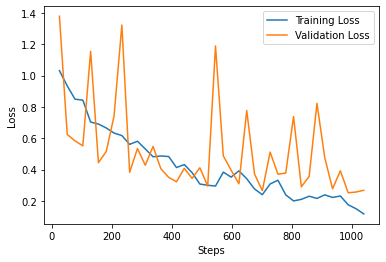

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

## Oversampling

In [ ]:
X_train['label'].value_counts()

1    2566
0     591
2     100
Name: label, dtype: int64

In [ ]:
#Oversampling
count_1, count_0, count_2 = X_train.label.value_counts()
df_0 = X_train[X_train['label'] == 0]
df_1 = X_train[X_train['label'] == 1]
df_2 = X_train[X_train['label'] == 2]
df_0_samples = (df_0.sample(count_1, replace=True, random_state=4211)).reset_index(drop=True)
df_2_samples = df_2.sample(count_1, replace=True, random_state=4211).reset_index(drop=True)
X_train1 = pd.concat([df_1, df_0_samples, df_2_samples], axis=0).reset_index(drop=True)
display(X_train1.tail())
print(X_train1.label.value_counts())
#data_df1.label.value_counts().plot(kind='bar', title='Count');

filename               dir_name  ... bb_ymax label
7693  maksssksksss52_35.png  wear_mask_incorrectly  ...      47     2
7694    maksssksksss2_3.png  wear_mask_incorrectly  ...      65     2
7695  maksssksksss371_0.png  wear_mask_incorrectly  ...     154     2
7696   maksssksksss29_1.png  wear_mask_incorrectly  ...     159     2
7697  maksssksksss613_9.png  wear_mask_incorrectly  ...     167     2

[5 rows x 12 columns]

2    2566
1    2566
0    2566
Name: label, dtype: int64


In [ ]:
#X_train1 = X_train1[:4000]
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7698 non-null   object
 1   dir_name  7698 non-null   object
 2   name      7698 non-null   object
 3   pose      7698 non-null   object
 4   trunc     7698 non-null   int64 
 5   occ       7698 non-null   int64 
 6   diff      7698 non-null   int64 
 7   bb_xmin   7698 non-null   int64 
 8   bb_ymin   7698 non-null   int64 
 9   bb_xmax   7698 non-null   int64 
 10  bb_ymax   7698 non-null   int64 
 11  label     7698 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 721.8+ KB


In [ ]:
# Load oversampled dataset
X_train1.to_csv('oversampled_data.csv')
train_path_os = '/content/oversampled_data.csv'
valid_path_os = '/content/valid.csv'
test_path_os = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train_os = FacemaskDataset(train_path_os, transform=transform_original)
dataset_valid_os = FacemaskDataset(valid_path_os, transform=transform_original)
dataset_test_os = FacemaskDataset(test_path_os, transform=transform_original)

# Create dataset iterators
bs = 128

train_loader_os = DataLoader(dataset_train_os, batch_size=bs, shuffle=True, num_workers=1, pin_memory=True)
valid_loader_os = DataLoader(dataset_valid_os, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
test_loader_os = DataLoader(dataset_test_os, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
print(train_loader_os)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2_oversampled.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_os, valid_loader_os, num_epochs, criterion, optimizer, device, save_path)


cuda


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffaaca61170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Model saved to pa2_oversampled.pt
Epoch [1/40], Step 61, Train Loss: 0.6885, Train Acc: 0.7078, Val Macro Avg: 0.5040, Valid Loss: 1.3600,  Valid Acc: 0.6020
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        63
           1       0.97      0.61      0.75       329
           2       0.09      0.93      0.16        15

    accuracy                           0.60       407
   macro avg       0.63      0.67      0.50       407
weighted avg       0.91      0.60      0.70       407




Epoch [2/40], Step 122, Train Loss: 0.3885, Train Acc: 0.8557, Val Macro Avg: 0.4264, Valid Loss: 2.7512,  Valid Acc: 0.4152
              precision    recall  f1-score   support

           0       0.80      0.52      0.63        63
           1       0.95      0.37      0.53       329
           2       0.06      0.93      0.11        15

    accuracy                           0.42       407
   macro avg       0.61      0.61      0.43       407
weighted avg       0.90      0.42      0.53       407




Model saved to pa2_oversampled.pt
Epoch [3/40], Step 183, Train Loss: 0.2613, Train Acc: 0.9061, Val Macro Avg: 0.5290, Valid Loss: 1.1594,  Valid Acc: 0.6953
              precision    recall  f1-score   support

           0       0.68      0.51      0.58        63
           1       0.98      0.73      0.83       329
           2       0.10      0.73      0.17        15

    accuracy                           0.70       407
   macro avg       0.58      0.66      0.53       407
weighted avg       0.90      0.70      0.77       407




Model saved to pa2_oversampled.pt
Epoch [4/40], Step 244, Train Loss: 0.2296, Train Acc: 0.9166, Val Macro Avg: 0.6516, Valid Loss: 0.4959,  Valid Acc: 0.8231
              precision    recall  f1-score   support

           0       0.55      0.92      0.69        63
           1       0.98      0.82      0.89       329
           2       0.29      0.53      0.37        15

    accuracy                           0.82       407
   macro avg       0.61      0.76      0.65       407
weighted avg       0.89      0.82      0.84       407




Model saved to pa2_oversampled.pt
Epoch [5/40], Step 305, Train Loss: 0.1728, Train Acc: 0.9405, Val Macro Avg: 0.6679, Valid Loss: 0.4572,  Valid Acc: 0.9066
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        63
           1       0.91      0.98      0.95       329
           2       0.50      0.20      0.29        15

    accuracy                           0.91       407
   macro avg       0.78      0.62      0.67       407
weighted avg       0.90      0.91      0.90       407




Model saved to pa2_oversampled.pt
Epoch [6/40], Step 366, Train Loss: 0.1638, Train Acc: 0.9436, Val Macro Avg: 0.6850, Valid Loss: 0.4280,  Valid Acc: 0.8526
              precision    recall  f1-score   support

           0       0.62      0.84      0.71        63
           1       0.97      0.87      0.91       329
           2       0.33      0.60      0.43        15

    accuracy                           0.85       407
   macro avg       0.64      0.77      0.68       407
weighted avg       0.89      0.85      0.87       407




Epoch [7/40], Step 427, Train Loss: 0.1299, Train Acc: 0.9539, Val Macro Avg: 0.6516, Valid Loss: 0.6219,  Valid Acc: 0.8182
              precision    recall  f1-score   support

           0       0.55      0.89      0.68        63
           1       0.98      0.81      0.89       329
           2       0.28      0.60      0.38        15

    accuracy                           0.82       407
   macro avg       0.60      0.77      0.65       407
weighted avg       0.89      0.82      0.84       407




Model saved to pa2_oversampled.pt
Epoch [8/40], Step 488, Train Loss: 0.1417, Train Acc: 0.9484, Val Macro Avg: 0.7666, Valid Loss: 0.3095,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        63
           1       0.96      0.96      0.96       329
           2       0.86      0.40      0.55        15

    accuracy                           0.92       407
   macro avg       0.85      0.74      0.77       407
weighted avg       0.92      0.92      0.92       407




Epoch [9/40], Step 549, Train Loss: 0.0981, Train Acc: 0.9651, Val Macro Avg: 0.7361, Valid Loss: 0.3446,  Valid Acc: 0.9140
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        63
           1       0.95      0.96      0.96       329
           2       0.83      0.33      0.48        15

    accuracy                           0.91       407
   macro avg       0.84      0.71      0.74       407
weighted avg       0.92      0.91      0.91       407




Epoch [10/40], Step 610, Train Loss: 0.0893, Train Acc: 0.9712, Val Macro Avg: 0.6691, Valid Loss: 0.6233,  Valid Acc: 0.8943
              precision    recall  f1-score   support

           0       0.94      0.54      0.69        63
           1       0.89      0.99      0.94       329
           2       0.67      0.27      0.38        15

    accuracy                           0.89       407
   macro avg       0.83      0.60      0.67       407
weighted avg       0.89      0.89      0.88       407




Epoch [11/40], Step 671, Train Loss: 0.1056, Train Acc: 0.9644, Val Macro Avg: 0.7344, Valid Loss: 0.3636,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.70      0.87      0.77        63
           1       0.96      0.94      0.95       329
           2       0.83      0.33      0.48        15

    accuracy                           0.91       407
   macro avg       0.83      0.72      0.73       407
weighted avg       0.92      0.91      0.91       407




Epoch [12/40], Step 732, Train Loss: 0.0764, Train Acc: 0.9754, Val Macro Avg: 0.7093, Valid Loss: 0.5902,  Valid Acc: 0.8575
              precision    recall  f1-score   support

           0       0.55      0.94      0.69        63
           1       0.98      0.86      0.92       329
           2       0.75      0.40      0.52        15

    accuracy                           0.86       407
   macro avg       0.76      0.73      0.71       407
weighted avg       0.90      0.86      0.87       407




Model saved to pa2_oversampled.pt
Epoch [13/40], Step 793, Train Loss: 0.0634, Train Acc: 0.9770, Val Macro Avg: 0.7911, Valid Loss: 0.2811,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        63
           1       0.96      0.97      0.97       329
           2       0.78      0.47      0.58        15

    accuracy                           0.93       407
   macro avg       0.85      0.76      0.79       407
weighted avg       0.93      0.93      0.93       407




Epoch [14/40], Step 854, Train Loss: 0.0710, Train Acc: 0.9766, Val Macro Avg: 0.7016, Valid Loss: 0.4771,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.67      0.87      0.76        63
           1       0.96      0.93      0.95       329
           2       0.80      0.27      0.40        15

    accuracy                           0.90       407
   macro avg       0.81      0.69      0.70       407
weighted avg       0.91      0.90      0.90       407




Epoch [15/40], Step 915, Train Loss: 0.0857, Train Acc: 0.9705, Val Macro Avg: 0.7632, Valid Loss: 0.3596,  Valid Acc: 0.8821
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        63
           1       0.97      0.89      0.93       329
           2       0.64      0.60      0.62        15

    accuracy                           0.88       407
   macro avg       0.75      0.80      0.76       407
weighted avg       0.90      0.88      0.89       407




Model saved to pa2_oversampled.pt
Epoch [16/40], Step 976, Train Loss: 0.0563, Train Acc: 0.9786, Val Macro Avg: 0.8238, Valid Loss: 0.3051,  Valid Acc: 0.9287
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        63
           1       0.97      0.95      0.96       329
           2       0.82      0.60      0.69        15

    accuracy                           0.93       407
   macro avg       0.85      0.81      0.82       407
weighted avg       0.93      0.93      0.93       407




Epoch [17/40], Step 1037, Train Loss: 0.0421, Train Acc: 0.9855, Val Macro Avg: 0.7884, Valid Loss: 0.5216,  Valid Acc: 0.9238
              precision    recall  f1-score   support

           0       0.95      0.63      0.76        63
           1       0.93      0.99      0.96       329
           2       0.69      0.60      0.64        15

    accuracy                           0.92       407
   macro avg       0.86      0.74      0.79       407
weighted avg       0.92      0.92      0.92       407




Epoch [18/40], Step 1098, Train Loss: 0.0743, Train Acc: 0.9739, Val Macro Avg: 0.5377, Valid Loss: 1.8620,  Valid Acc: 0.6118
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        63
           1       0.96      0.59      0.73       329
           2       0.07      0.73      0.13        15

    accuracy                           0.61       407
   macro avg       0.61      0.68      0.54       407
weighted avg       0.90      0.61      0.71       407




Model saved to pa2_oversampled.pt
Epoch [19/40], Step 1159, Train Loss: 0.0655, Train Acc: 0.9792, Val Macro Avg: 0.8251, Valid Loss: 0.2963,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        63
           1       0.95      0.97      0.96       329
           2       1.00      0.53      0.70        15

    accuracy                           0.93       407
   macro avg       0.92      0.78      0.83       407
weighted avg       0.93      0.93      0.93       407




Epoch [20/40], Step 1220, Train Loss: 0.0842, Train Acc: 0.9717, Val Macro Avg: 0.7167, Valid Loss: 0.5054,  Valid Acc: 0.8477
              precision    recall  f1-score   support

           0       0.54      0.89      0.67        63
           1       0.97      0.85      0.91       329
           2       0.62      0.53      0.57        15

    accuracy                           0.85       407
   macro avg       0.71      0.76      0.72       407
weighted avg       0.89      0.85      0.86       407




Epoch [21/40], Step 1281, Train Loss: 0.0388, Train Acc: 0.9865, Val Macro Avg: 0.8023, Valid Loss: 0.3097,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        63
           1       0.95      0.98      0.96       329
           2       1.00      0.47      0.64        15

    accuracy                           0.93       407
   macro avg       0.92      0.75      0.80       407
weighted avg       0.93      0.93      0.93       407




Epoch [22/40], Step 1342, Train Loss: 0.0311, Train Acc: 0.9891, Val Macro Avg: 0.7785, Valid Loss: 0.4142,  Valid Acc: 0.9091
              precision    recall  f1-score   support

           0       0.69      0.89      0.78        63
           1       0.97      0.93      0.95       329
           2       0.88      0.47      0.61        15

    accuracy                           0.91       407
   macro avg       0.84      0.76      0.78       407
weighted avg       0.92      0.91      0.91       407




Epoch [23/40], Step 1403, Train Loss: 0.0732, Train Acc: 0.9753, Val Macro Avg: 0.7024, Valid Loss: 0.4434,  Valid Acc: 0.9214
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        63
           1       0.95      0.96      0.96       329
           2       1.00      0.20      0.33        15

    accuracy                           0.92       407
   macro avg       0.91      0.68      0.70       407
weighted avg       0.93      0.92      0.91       407




Epoch [24/40], Step 1464, Train Loss: 0.0293, Train Acc: 0.9891, Val Macro Avg: 0.7902, Valid Loss: 0.4642,  Valid Acc: 0.9361
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        63
           1       0.94      0.99      0.97       329
           2       1.00      0.40      0.57        15

    accuracy                           0.94       407
   macro avg       0.94      0.73      0.79       407
weighted avg       0.94      0.94      0.93       407




Epoch [25/40], Step 1525, Train Loss: 0.0260, Train Acc: 0.9917, Val Macro Avg: 0.7944, Valid Loss: 0.4350,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.78      0.79      0.79        63
           1       0.95      0.95      0.95       329
           2       0.69      0.60      0.64        15

    accuracy                           0.92       407
   macro avg       0.81      0.78      0.79       407
weighted avg       0.92      0.92      0.92       407




Epoch [26/40], Step 1586, Train Loss: 0.0253, Train Acc: 0.9917, Val Macro Avg: 0.6697, Valid Loss: 0.8684,  Valid Acc: 0.8305
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        63
           1       0.97      0.84      0.90       329
           2       0.23      0.80      0.36        15

    accuracy                           0.83       407
   macro avg       0.64      0.81      0.67       407
weighted avg       0.90      0.83      0.86       407




Epoch [27/40], Step 1647, Train Loss: 0.0956, Train Acc: 0.9682, Val Macro Avg: 0.7650, Valid Loss: 0.3541,  Valid Acc: 0.9337
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        63
           1       0.96      0.98      0.97       329
           2       1.00      0.33      0.50        15

    accuracy                           0.93       407
   macro avg       0.92      0.72      0.77       407
weighted avg       0.94      0.93      0.93       407




Epoch [28/40], Step 1708, Train Loss: 0.0318, Train Acc: 0.9897, Val Macro Avg: 0.8100, Valid Loss: 0.3222,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        63
           1       0.95      0.98      0.97       329
           2       0.73      0.53      0.62        15

    accuracy                           0.94       407
   macro avg       0.86      0.77      0.81       407
weighted avg       0.94      0.94      0.94       407




Epoch [29/40], Step 1769, Train Loss: 0.0245, Train Acc: 0.9912, Val Macro Avg: 0.8038, Valid Loss: 0.4171,  Valid Acc: 0.9042
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        63
           1       0.96      0.93      0.94       329
           2       0.63      0.80      0.71        15

    accuracy                           0.90       407
   macro avg       0.77      0.85      0.80       407
weighted avg       0.91      0.90      0.91       407




Epoch [30/40], Step 1830, Train Loss: 0.0184, Train Acc: 0.9932, Val Macro Avg: 0.7591, Valid Loss: 0.5381,  Valid Acc: 0.8993
              precision    recall  f1-score   support

           0       0.65      0.87      0.75        63
           1       0.97      0.92      0.95       329
           2       0.78      0.47      0.58        15

    accuracy                           0.90       407
   macro avg       0.80      0.75      0.76       407
weighted avg       0.91      0.90      0.90       407




Epoch [31/40], Step 1891, Train Loss: 0.0183, Train Acc: 0.9940, Val Macro Avg: 0.7955, Valid Loss: 0.3827,  Valid Acc: 0.9165
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        63
           1       0.96      0.95      0.95       329
           2       0.80      0.53      0.64        15

    accuracy                           0.92       407
   macro avg       0.83      0.78      0.80       407
weighted avg       0.92      0.92      0.92       407




Epoch [32/40], Step 1952, Train Loss: 0.0103, Train Acc: 0.9964, Val Macro Avg: 0.8115, Valid Loss: 0.4365,  Valid Acc: 0.9189
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        63
           1       0.96      0.95      0.95       329
           2       0.82      0.60      0.69        15

    accuracy                           0.92       407
   macro avg       0.84      0.79      0.81       407
weighted avg       0.92      0.92      0.92       407




Model saved to pa2_oversampled.pt
Epoch [33/40], Step 2013, Train Loss: 0.0107, Train Acc: 0.9969, Val Macro Avg: 0.8319, Valid Loss: 0.4359,  Valid Acc: 0.9410
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        63
           1       0.96      0.98      0.97       329
           2       0.82      0.60      0.69        15

    accuracy                           0.94       407
   macro avg       0.88      0.79      0.83       407
weighted avg       0.94      0.94      0.94       407




Epoch [34/40], Step 2074, Train Loss: 0.0225, Train Acc: 0.9939, Val Macro Avg: 0.7217, Valid Loss: 0.7280,  Valid Acc: 0.8452
              precision    recall  f1-score   support

           0       0.53      0.90      0.67        63
           1       0.97      0.85      0.91       329
           2       0.67      0.53      0.59        15

    accuracy                           0.85       407
   macro avg       0.72      0.76      0.72       407
weighted avg       0.89      0.85      0.86       407




Epoch [35/40], Step 2135, Train Loss: 0.0332, Train Acc: 0.9892, Val Macro Avg: 0.8042, Valid Loss: 0.5219,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.95      0.63      0.76        63
           1       0.94      0.99      0.96       329
           2       0.65      0.73      0.69        15

    accuracy                           0.93       407
   macro avg       0.85      0.79      0.80       407
weighted avg       0.93      0.93      0.92       407




Epoch [36/40], Step 2196, Train Loss: 0.0502, Train Acc: 0.9817, Val Macro Avg: 0.7999, Valid Loss: 0.3024,  Valid Acc: 0.9386
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        63
           1       0.96      0.98      0.97       329
           2       0.78      0.47      0.58        15

    accuracy                           0.94       407
   macro avg       0.86      0.76      0.80       407
weighted avg       0.94      0.94      0.94       407




Epoch [37/40], Step 2257, Train Loss: 0.0433, Train Acc: 0.9845, Val Macro Avg: 0.8056, Valid Loss: 0.3263,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        63
           1       0.97      0.96      0.97       329
           2       0.59      0.67      0.62        15

    accuracy                           0.93       407
   macro avg       0.79      0.82      0.81       407
weighted avg       0.93      0.93      0.93       407




Epoch [38/40], Step 2318, Train Loss: 0.0110, Train Acc: 0.9962, Val Macro Avg: 0.7964, Valid Loss: 0.3826,  Valid Acc: 0.9312
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        63
           1       0.96      0.98      0.97       329
           2       0.64      0.60      0.62        15

    accuracy                           0.93       407
   macro avg       0.81      0.78      0.80       407
weighted avg       0.93      0.93      0.93       407




Epoch [39/40], Step 2379, Train Loss: 0.0117, Train Acc: 0.9962, Val Macro Avg: 0.7919, Valid Loss: 0.4709,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        63
           1       0.95      0.97      0.96       329
           2       0.88      0.47      0.61        15

    accuracy                           0.93       407
   macro avg       0.87      0.75      0.79       407
weighted avg       0.93      0.93      0.92       407




Epoch [40/40], Step 2440, Train Loss: 0.0062, Train Acc: 0.9981, Val Macro Avg: 0.7793, Valid Loss: 0.4530,  Valid Acc: 0.9263
              precision    recall  f1-score   support

           0       0.87      0.73      0.79        63
           1       0.94      0.98      0.96       329
           2       0.78      0.47      0.58        15

    accuracy                           0.93       407
   macro avg       0.86      0.73      0.78       407
weighted avg       0.92      0.93      0.92       407

Finished Training
Best validation macro average: 0.8319003019601823
Best validation loss: 0.4358631932561474


In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

## Undersampling

In [ ]:
#Undersampling
count_1, count_0, count_2 = X_train.label.value_counts()
df_0 = X_train[X_train['label'] == 0]
df_1 = X_train[X_train['label'] == 1]
df_2 = X_train[X_train['label'] == 2]
df_1_samples = df_1.sample(count_2, random_state=4211).reset_index(drop=True)
df_0_samples = df_0.sample(count_2, random_state=4211).reset_index(drop=True)
X_train2 = pd.concat([df_2, df_0_samples, df_1_samples], axis=0).reset_index(drop=True)
print(X_train2.label.value_counts())
#data_df1.label.value_counts().plot(kind='bar', title='Count');

2    100
1    100
0    100
Name: label, dtype: int64


In [ ]:
# Load undersampled dataset
X_train2.to_csv('undersampled_data.csv')
train_path_us = '/content/undersampled_data.csv'
valid_path_us = '/content/valid.csv'
test_path_us = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train_us = FacemaskDataset(train_path_us, transform=transform_original)
dataset_valid_us = FacemaskDataset(valid_path_us, transform=transform_original)
dataset_test_us = FacemaskDataset(test_path_us, transform=transform_original)

# Create dataset iterators
bs = 64

train_loader_us = DataLoader(dataset_train_us, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_us = DataLoader(dataset_valid_us, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_us = DataLoader(dataset_test_us, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2_undersampled.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_us, valid_loader_us, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2_undersampled.pt
Epoch [1/40], Step 5, Train Loss: 1.0792, Train Acc: 0.4367, Val Macro Avg: 0.0894, Valid Loss: 1.1505,  Valid Acc: 0.1548
              precision    recall  f1-score   support

           0       0.15      1.00      0.27        63
           1       0.00      0.00      0.00       329
           2       0.00      0.00      0.00        15

    accuracy                           0.15       407
   macro avg       0.05      0.33      0.09       407
weighted avg       0.02      0.15      0.04       407



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [2/40], Step 10, Train Loss: 0.9878, Train Acc: 0.5333, Val Macro Avg: 0.0894, Valid Loss: 1.4381,  Valid Acc: 0.1548
              precision    recall  f1-score   support

           0       0.15      1.00      0.27        63
           1       0.00      0.00      0.00       329
           2       0.00      0.00      0.00        15

    accuracy                           0.15       407
   macro avg       0.05      0.33      0.09       407
weighted avg       0.02      0.15      0.04       407




Model saved to pa2_undersampled.pt
Epoch [3/40], Step 15, Train Loss: 0.8810, Train Acc: 0.6033, Val Macro Avg: 0.2310, Valid Loss: 1.0500,  Valid Acc: 0.3464
              precision    recall  f1-score   support

           0       0.17      0.79      0.28        63
           1       0.85      0.28      0.42       329
           2       0.00      0.00      0.00        15

    accuracy                           0.35       407
   macro avg       0.34      0.36      0.23       407
weighted avg       0.71      0.35      0.38       407




Epoch [4/40], Step 20, Train Loss: 0.7985, Train Acc: 0.6200, Val Macro Avg: 0.0916, Valid Loss: 1.7603,  Valid Acc: 0.1572
              precision    recall  f1-score   support

           0       0.16      1.00      0.27        63
           1       1.00      0.00      0.01       329
           2       0.00      0.00      0.00        15

    accuracy                           0.16       407
   macro avg       0.39      0.33      0.09       407
weighted avg       0.83      0.16      0.05       407




Epoch [5/40], Step 25, Train Loss: 0.7285, Train Acc: 0.6833, Val Macro Avg: 0.1663, Valid Loss: 2.4076,  Valid Acc: 0.2482
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        63
           1       0.97      0.12      0.21       329
           2       0.00      0.00      0.00        15

    accuracy                           0.25       407
   macro avg       0.38      0.37      0.17       407
weighted avg       0.81      0.25      0.21       407




Epoch [6/40], Step 30, Train Loss: 0.7096, Train Acc: 0.6933, Val Macro Avg: 0.2069, Valid Loss: 1.8101,  Valid Acc: 0.3047
              precision    recall  f1-score   support

           0       0.18      1.00      0.31        63
           1       0.98      0.19      0.31       329
           2       0.00      0.00      0.00        15

    accuracy                           0.30       407
   macro avg       0.39      0.40      0.21       407
weighted avg       0.82      0.30      0.30       407




Model saved to pa2_undersampled.pt
Epoch [7/40], Step 35, Train Loss: 0.6472, Train Acc: 0.7200, Val Macro Avg: 0.3086, Valid Loss: 1.7829,  Valid Acc: 0.4668
              precision    recall  f1-score   support

           0       0.23      0.97      0.37        63
           1       0.96      0.39      0.56       329
           2       0.00      0.00      0.00        15

    accuracy                           0.47       407
   macro avg       0.39      0.45      0.31       407
weighted avg       0.81      0.47      0.51       407




Model saved to pa2_undersampled.pt
Epoch [8/40], Step 40, Train Loss: 0.7305, Train Acc: 0.6933, Val Macro Avg: 0.4278, Valid Loss: 1.2476,  Valid Acc: 0.5283
              precision    recall  f1-score   support

           0       0.26      0.95      0.41        63
           1       0.98      0.46      0.62       329
           2       0.20      0.33      0.25        15

    accuracy                           0.53       407
   macro avg       0.48      0.58      0.43       407
weighted avg       0.84      0.53      0.58       407




Model saved to pa2_undersampled.pt
Epoch [9/40], Step 45, Train Loss: 0.6158, Train Acc: 0.7367, Val Macro Avg: 0.4318, Valid Loss: 1.0532,  Valid Acc: 0.5332
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        63
           1       0.97      0.52      0.68       329
           2       0.07      0.67      0.12        15

    accuracy                           0.53       407
   macro avg       0.49      0.58      0.43       407
weighted avg       0.85      0.53      0.63       407




Model saved to pa2_undersampled.pt
Epoch [10/40], Step 50, Train Loss: 0.5600, Train Acc: 0.8033, Val Macro Avg: 0.4694, Valid Loss: 0.9963,  Valid Acc: 0.5725
              precision    recall  f1-score   support

           0       0.52      0.56      0.54        63
           1       0.96      0.56      0.71       329
           2       0.09      0.87      0.16        15

    accuracy                           0.57       407
   macro avg       0.52      0.66      0.47       407
weighted avg       0.86      0.57      0.66       407




Model saved to pa2_undersampled.pt
Epoch [11/40], Step 55, Train Loss: 0.5420, Train Acc: 0.7933, Val Macro Avg: 0.5449, Valid Loss: 0.7064,  Valid Acc: 0.7248
              precision    recall  f1-score   support

           0       0.42      0.81      0.56        63
           1       0.96      0.72      0.82       329
           2       0.17      0.47      0.25        15

    accuracy                           0.72       407
   macro avg       0.52      0.67      0.54       407
weighted avg       0.85      0.72      0.76       407




Epoch [12/40], Step 60, Train Loss: 0.4541, Train Acc: 0.8067, Val Macro Avg: 0.2976, Valid Loss: 1.3846,  Valid Acc: 0.4005
              precision    recall  f1-score   support

           0       0.21      0.98      0.35        63
           1       0.98      0.30      0.46       329
           2       0.11      0.07      0.08        15

    accuracy                           0.40       407
   macro avg       0.43      0.45      0.30       407
weighted avg       0.83      0.40      0.43       407




Epoch [13/40], Step 65, Train Loss: 0.5271, Train Acc: 0.8000, Val Macro Avg: 0.5339, Valid Loss: 1.1232,  Valid Acc: 0.6437
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        63
           1       0.98      0.62      0.76       329
           2       0.10      0.87      0.18        15

    accuracy                           0.64       407
   macro avg       0.57      0.73      0.53       407
weighted avg       0.89      0.64      0.72       407




Epoch [14/40], Step 70, Train Loss: 0.4317, Train Acc: 0.8300, Val Macro Avg: 0.4634, Valid Loss: 1.4383,  Valid Acc: 0.5405
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        63
           1       0.96      0.53      0.68       329
           2       0.07      0.73      0.12        15

    accuracy                           0.54       407
   macro avg       0.55      0.61      0.46       407
weighted avg       0.87      0.54      0.65       407




Epoch [15/40], Step 75, Train Loss: 0.4511, Train Acc: 0.8300, Val Macro Avg: 0.5413, Valid Loss: 0.5103,  Valid Acc: 0.8477
              precision    recall  f1-score   support

           0       0.62      0.57      0.60        63
           1       0.89      0.94      0.91       329
           2       0.50      0.07      0.12        15

    accuracy                           0.85       407
   macro avg       0.67      0.52      0.54       407
weighted avg       0.83      0.85      0.83       407




Model saved to pa2_undersampled.pt
Epoch [16/40], Step 80, Train Loss: 0.3852, Train Acc: 0.8567, Val Macro Avg: 0.5631, Valid Loss: 0.8395,  Valid Acc: 0.7445
              precision    recall  f1-score   support

           0       0.50      0.79      0.61        63
           1       0.96      0.74      0.84       329
           2       0.15      0.53      0.24        15

    accuracy                           0.74       407
   macro avg       0.54      0.69      0.56       407
weighted avg       0.86      0.74      0.78       407




Model saved to pa2_undersampled.pt
Epoch [17/40], Step 85, Train Loss: 0.4256, Train Acc: 0.8400, Val Macro Avg: 0.6268, Valid Loss: 0.5023,  Valid Acc: 0.8206
              precision    recall  f1-score   support

           0       0.56      0.86      0.68        63
           1       0.95      0.83      0.89       329
           2       0.26      0.40      0.32        15

    accuracy                           0.82       407
   macro avg       0.59      0.70      0.63       407
weighted avg       0.87      0.82      0.84       407




Epoch [18/40], Step 90, Train Loss: 0.3002, Train Acc: 0.8800, Val Macro Avg: 0.5297, Valid Loss: 0.9622,  Valid Acc: 0.6732
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        63
           1       0.95      0.67      0.78       329
           2       0.11      0.67      0.18        15

    accuracy                           0.67       407
   macro avg       0.54      0.68      0.53       407
weighted avg       0.86      0.67      0.74       407




Epoch [19/40], Step 95, Train Loss: 0.2857, Train Acc: 0.8900, Val Macro Avg: 0.3838, Valid Loss: 1.6981,  Valid Acc: 0.4423
              precision    recall  f1-score   support

           0       0.22      0.97      0.36        63
           1       0.97      0.35      0.51       329
           2       0.29      0.27      0.28        15

    accuracy                           0.44       407
   macro avg       0.49      0.53      0.38       407
weighted avg       0.83      0.44      0.48       407




Epoch [20/40], Step 100, Train Loss: 0.2808, Train Acc: 0.9000, Val Macro Avg: 0.5701, Valid Loss: 0.8882,  Valid Acc: 0.7174
              precision    recall  f1-score   support

           0       0.53      0.84      0.65        63
           1       0.97      0.69      0.81       329
           2       0.15      0.73      0.25        15

    accuracy                           0.72       407
   macro avg       0.55      0.76      0.57       407
weighted avg       0.88      0.72      0.76       407




Epoch [21/40], Step 105, Train Loss: 0.2364, Train Acc: 0.9233, Val Macro Avg: 0.4382, Valid Loss: 1.4274,  Valid Acc: 0.5233
              precision    recall  f1-score   support

           0       0.27      0.95      0.42        63
           1       0.98      0.44      0.61       329
           2       0.21      0.47      0.29        15

    accuracy                           0.52       407
   macro avg       0.48      0.62      0.44       407
weighted avg       0.84      0.52      0.57       407




Model saved to pa2_undersampled.pt
Epoch [22/40], Step 110, Train Loss: 0.2691, Train Acc: 0.9000, Val Macro Avg: 0.6625, Valid Loss: 0.4690,  Valid Acc: 0.8526
              precision    recall  f1-score   support

           0       0.65      0.75      0.70        63
           1       0.94      0.89      0.91       329
           2       0.32      0.47      0.38        15

    accuracy                           0.85       407
   macro avg       0.64      0.70      0.66       407
weighted avg       0.87      0.85      0.86       407




Epoch [23/40], Step 115, Train Loss: 0.2704, Train Acc: 0.9000, Val Macro Avg: 0.4738, Valid Loss: 2.3442,  Valid Acc: 0.5602
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        63
           1       0.98      0.55      0.70       329
           2       0.08      0.93      0.15        15

    accuracy                           0.56       407
   macro avg       0.56      0.67      0.47       407
weighted avg       0.89      0.56      0.66       407




Epoch [24/40], Step 120, Train Loss: 0.3015, Train Acc: 0.8733, Val Macro Avg: 0.4680, Valid Loss: 1.9505,  Valid Acc: 0.5897
              precision    recall  f1-score   support

           0       0.43      0.76      0.55        63
           1       0.97      0.56      0.71       329
           2       0.08      0.60      0.15        15

    accuracy                           0.59       407
   macro avg       0.49      0.64      0.47       407
weighted avg       0.85      0.59      0.66       407




Epoch [25/40], Step 125, Train Loss: 0.2901, Train Acc: 0.9000, Val Macro Avg: 0.6221, Valid Loss: 0.6392,  Valid Acc: 0.8698
              precision    recall  f1-score   support

           0       0.61      0.84      0.71        63
           1       0.94      0.91      0.92       329
           2       1.00      0.13      0.24        15

    accuracy                           0.87       407
   macro avg       0.85      0.63      0.62       407
weighted avg       0.89      0.87      0.87       407




Epoch [26/40], Step 130, Train Loss: 0.2332, Train Acc: 0.9100, Val Macro Avg: 0.5547, Valid Loss: 0.9051,  Valid Acc: 0.7199
              precision    recall  f1-score   support

           0       0.71      0.59      0.64        63
           1       0.91      0.75      0.82       329
           2       0.12      0.67      0.20        15

    accuracy                           0.72       407
   macro avg       0.58      0.67      0.55       407
weighted avg       0.85      0.72      0.77       407




Epoch [27/40], Step 135, Train Loss: 0.2197, Train Acc: 0.9167, Val Macro Avg: 0.5511, Valid Loss: 0.9646,  Valid Acc: 0.7371
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        63
           1       0.92      0.78      0.84       329
           2       0.13      0.67      0.22        15

    accuracy                           0.74       407
   macro avg       0.56      0.67      0.55       407
weighted avg       0.85      0.74      0.78       407




Epoch [28/40], Step 140, Train Loss: 0.1856, Train Acc: 0.9233, Val Macro Avg: 0.5885, Valid Loss: 0.8346,  Valid Acc: 0.7518
              precision    recall  f1-score   support

           0       0.55      0.81      0.65        63
           1       0.96      0.74      0.84       329
           2       0.17      0.67      0.27        15

    accuracy                           0.75       407
   macro avg       0.56      0.74      0.59       407
weighted avg       0.86      0.75      0.79       407




Epoch [29/40], Step 145, Train Loss: 0.1848, Train Acc: 0.9367, Val Macro Avg: 0.5935, Valid Loss: 0.7294,  Valid Acc: 0.7764
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        63
           1       0.95      0.80      0.87       329
           2       0.18      0.67      0.28        15

    accuracy                           0.78       407
   macro avg       0.57      0.72      0.59       407
weighted avg       0.86      0.78      0.81       407




Epoch [30/40], Step 150, Train Loss: 0.1633, Train Acc: 0.9467, Val Macro Avg: 0.5177, Valid Loss: 1.5844,  Valid Acc: 0.6290
              precision    recall  f1-score   support

           0       0.57      0.71      0.63        63
           1       0.98      0.60      0.75       329
           2       0.10      0.80      0.17        15

    accuracy                           0.63       407
   macro avg       0.55      0.71      0.52       407
weighted avg       0.88      0.63      0.71       407




Epoch [31/40], Step 155, Train Loss: 0.1502, Train Acc: 0.9467, Val Macro Avg: 0.6127, Valid Loss: 0.7245,  Valid Acc: 0.7912
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        63
           1       0.96      0.81      0.88       329
           2       0.21      0.67      0.32        15

    accuracy                           0.79       407
   macro avg       0.58      0.74      0.61       407
weighted avg       0.87      0.79      0.82       407




Epoch [32/40], Step 160, Train Loss: 0.1411, Train Acc: 0.9433, Val Macro Avg: 0.6161, Valid Loss: 0.5002,  Valid Acc: 0.8624
              precision    recall  f1-score   support

           0       0.70      0.62      0.66        63
           1       0.92      0.94      0.93       329
           2       0.27      0.27      0.27        15

    accuracy                           0.86       407
   macro avg       0.63      0.61      0.62       407
weighted avg       0.86      0.86      0.86       407




Epoch [33/40], Step 165, Train Loss: 0.1030, Train Acc: 0.9533, Val Macro Avg: 0.6429, Valid Loss: 0.5811,  Valid Acc: 0.8206
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        63
           1       0.97      0.84      0.90       329
           2       0.24      0.67      0.35        15

    accuracy                           0.82       407
   macro avg       0.60      0.76      0.64       407
weighted avg       0.89      0.82      0.84       407




Epoch [34/40], Step 170, Train Loss: 0.1092, Train Acc: 0.9667, Val Macro Avg: 0.5982, Valid Loss: 0.7406,  Valid Acc: 0.7690
              precision    recall  f1-score   support

           0       0.49      0.83      0.61        63
           1       0.97      0.77      0.86       329
           2       0.23      0.60      0.33        15

    accuracy                           0.77       407
   macro avg       0.56      0.73      0.60       407
weighted avg       0.87      0.77      0.80       407




Epoch [35/40], Step 175, Train Loss: 0.1326, Train Acc: 0.9500, Val Macro Avg: 0.5994, Valid Loss: 0.8386,  Valid Acc: 0.7764
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        63
           1       0.96      0.78      0.86       329
           2       0.15      0.60      0.23        15

    accuracy                           0.78       407
   macro avg       0.58      0.72      0.60       407
weighted avg       0.88      0.78      0.82       407




Epoch [36/40], Step 180, Train Loss: 0.1143, Train Acc: 0.9600, Val Macro Avg: 0.5941, Valid Loss: 0.9213,  Valid Acc: 0.7813
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        63
           1       0.96      0.81      0.88       329
           2       0.16      0.67      0.25        15

    accuracy                           0.78       407
   macro avg       0.58      0.71      0.59       407
weighted avg       0.88      0.78      0.82       407




Epoch [37/40], Step 185, Train Loss: 0.0981, Train Acc: 0.9600, Val Macro Avg: 0.5924, Valid Loss: 0.9394,  Valid Acc: 0.7641
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        63
           1       0.96      0.78      0.86       329
           2       0.14      0.67      0.22        15

    accuracy                           0.76       407
   macro avg       0.59      0.72      0.59       407
weighted avg       0.88      0.76      0.81       407




Epoch [38/40], Step 190, Train Loss: 0.1202, Train Acc: 0.9533, Val Macro Avg: 0.6078, Valid Loss: 0.6850,  Valid Acc: 0.8034
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        63
           1       0.94      0.82      0.88       329
           2       0.16      0.47      0.23        15

    accuracy                           0.80       407
   macro avg       0.58      0.69      0.61       407
weighted avg       0.87      0.80      0.83       407




Epoch [39/40], Step 195, Train Loss: 0.1332, Train Acc: 0.9567, Val Macro Avg: 0.4750, Valid Loss: 2.2317,  Valid Acc: 0.5774
              precision    recall  f1-score   support

           0       0.48      0.63      0.55        63
           1       0.98      0.55      0.71       329
           2       0.09      0.87      0.17        15

    accuracy                           0.58       407
   macro avg       0.52      0.68      0.47       407
weighted avg       0.87      0.58      0.66       407




Epoch [40/40], Step 200, Train Loss: 0.2169, Train Acc: 0.9300, Val Macro Avg: 0.5637, Valid Loss: 1.1118,  Valid Acc: 0.7371
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        63
           1       0.95      0.75      0.84       329
           2       0.13      0.67      0.22        15

    accuracy                           0.74       407
   macro avg       0.56      0.70      0.56       407
weighted avg       0.87      0.74      0.79       407

Finished Training
Best validation macro average: 0.6624824201148188
Best validation loss: 0.46900112678904404


In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

Testing


In [ ]:
#testing
count = 10

df_0 = X_train[X_train['label'] == 0]
df_1 = X_train[X_train['label'] == 1]
df_2 = X_train[X_train['label'] == 2]
df_1_samples = df_1.sample(count, random_state=4211)
df_0_samples = df_0.sample(count, random_state=4211)
df_2_samples = df_2.sample(count, random_state=4211)
X_train3 = pd.concat([df_2_samples, df_0_samples, df_1_samples], axis=0)
print(X_train3.label.value_counts())
#data_df1.label.value_counts().plot(kind='bar', title='Count');

2    10
1    10
0    10
Name: label, dtype: int64


In [ ]:
# Load undersampled dataset
X_train2.to_csv('undersampled_data.csv')
train_path_test = '/content/undersampled_data.csv'
valid_path_test = '/content/valid.csv'
test_path_test = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train_test = FacemaskDataset(train_path_test, transform=transform_original)
dataset_valid_test = FacemaskDataset(valid_path_test, transform=transform_original)
dataset_test_test = FacemaskDataset(test_path_test, transform=transform_original)

# Create dataset iterators
bs = 128

train_loader_tetestst = DataLoader(dataset_train_test, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_v = DataLoader(dataset_valid_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_us = DataLoader(dataset_test_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Test best model on Test dataset

In [ ]:
# Best model was the RGBmodel
#net = torch.load('/content/RGBNet_best.pt')
net = torch.load('/content/RGBNet_and_transform_best.pt')
#net = torch.load('/content/transformations_pa2net_best.pt')
#net = torch.load('/content/pa2net_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader_rgb:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_rgb)
  valid_acc = val_running_corrects / float(len(valid_loader_rgb.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.98      0.97      0.97       337
           2       0.50      0.75      0.60         8

    accuracy                           0.95       408
   macro avg       0.79      0.87      0.82       408
weighted avg       0.96      0.95      0.95       408

